In [1]:
#Date:  April 14, 2021
#Name:  Peida Han
#ID:    2449620842
#Email: peidahan@usc.edu
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision as tv
import torchvision.transforms as transforms
import time

import matplotlib.pyplot as plt
import numpy as np 

print(torch.cuda.is_available())
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev)
print(device)

True
cuda:0


In [2]:
def load_MNIST_data(train_batch_size,test_batch_size):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))])
    
    train_set=tv.datasets.MNIST(
        root='./data/',
        train=True,
        download=True,
        transform=transform
    )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_set=tv.datasets.MNIST(
        root='./data/',
        train=False,
        download=True,
        transform=transform
    )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )
    print('Data loaded')
    return train_loader,test_loader


In [3]:
def load_Fashion_data(train_batch_size,test_batch_size):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))])
    
    train_set=tv.datasets.FashionMNIST(
        root='./data/',
        train=True,
        download=True,
        transform=transform
    )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_set=tv.datasets.FashionMNIST(
        root='./data/',
        train=False,
        download=True,
        transform=transform
    )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )
    print('Data loaded')
    return train_loader,test_loader

In [4]:
def load_CIFAR_data(train_batch_size,test_batch_size):
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    
    train_set=tv.datasets.CIFAR10(
        root='./data/',
        train=True,
        download=True,
        transform=transform
    )
    train_loader=torch.utils.data.DataLoader(
        train_set,
        batch_size=train_batch_size,
        shuffle=True,
        num_workers=2
    )
    
    test_set=tv.datasets.CIFAR10(
        root='./data/',
        train=False,
        download=True,
        transform=transform
    )
    test_loader=torch.utils.data.DataLoader(
        test_set,
        batch_size=test_batch_size,
        shuffle=False,
        num_workers=2
    )
    print('Data loaded')
    return train_loader,test_loader

In [5]:
class CNN(nn.Module):

    def __init__(self,channel,size):
        super(CNN, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.size=size
        
        self.conv1 = nn.Conv2d(channel, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        if self.size==28:
            x=F.pad(x,(2,2,2,2))
            
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        #print(x.size())
        x = x.view(-1, self.num_flat_features(x))
        
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [6]:
def train(cnn,optimizer,criterion,trainloader,testloader,epochs,device):
    running_loss=0.0
    correct=0
    total=0
    iter=0
    for i, data in enumerate(trainloader,0):
        inputs,labels=data
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        #batch_size*10
        outputs=cnn(inputs)

        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        predicted = torch.argmax(outputs, 1)

        corr = (predicted == labels)
        for j in range(labels.size(0)):
            if corr[j].item():
                correct+=1
            
        running_loss+=loss.item()
        iter=iter+1
        if iter%2000==1999:
            print('[%d, %5d] loss:%.5f'%(epochs+1,iter+1,running_loss/2000))
            running_loss=0
        total+=labels.size(0)
    train_acc=correct/total    
    test_acc=predict(device,cnn,testloader)

    return train_acc,test_acc     


In [7]:
def predict(device,cnn,testloader):
    correct=0
    total=0
    with torch.no_grad():
        for i, data in enumerate(testloader):
                inputs,labels=data
                inputs=inputs.to(device)
                labels=labels.to(device)
                labels=labels.float()

                #batch_size*10
                outputs=cnn(inputs)
                predicted = torch.argmax(outputs, 1)

                corr = (predicted == labels)
                for i in range(labels.size(0)):
                    if corr[i].item():
                        correct=correct+1
                total+=labels.size(0)
    return correct/total      
    

In [8]:
def main(best,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epochs,learning_rate,momentum,weight_decay):
    cnn=CNN(channel,size)
    cnn=cnn.to(device)
    #     def weights_init(m):
    #         if isinstance(m,nn.Conv2d):
    #             torch.nn.init.xavier_uniform_(m.weight)
    #             torch.nn.init.zeros_(m.bias)
    #     cnn.apply(weights_init) 
    
    optimizer = optim.SGD(cnn.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss().to(device)
    
    train_acc=[]
    test_acc=[]

    for epoch in range(epochs):        
        train_a,test_a=train(cnn,optimizer,criterion,trainloader,testloader,epoch,device)   
        train_acc.append(train_a*100)
        test_acc.append(test_a*100)
        print('epoch:',epoch+1,'train accuary:',train_a,' test accuary:',test_a)
    print('-----Training ends-----')
    plt.plot(train_acc,label='train acc')
    plt.plot(test_acc,label='test acc')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy %')
    plt.title('Performance Curve')
    plt.legend()
    plt.show()
    if best==1:
        PATH='state_dict_model.pt'
        torch.save({'model_state_dict': cnn.state_dict()}, PATH)

    return train_acc,test_acc


In [9]:
def meanTrainResults(best,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay):
    multiple_train_acc=[]
    multiple_test_acc=[]

    for i in range(5):

        start_time=time.time()
        train_acc,test_acc=main(best,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)
        multiple_train_acc.append(train_acc[-1])    
        multiple_test_acc.append(test_acc[-1])

        end_time=(time.time()-start_time)/60
        print('round:',i+1,' total time used:',end_time)


    best_acc_train=np.max(multiple_train_acc)
    mean_acc_train=np.mean(multiple_train_acc)
    std_acc_train=np.std(multiple_train_acc)
    print('Best train accuracy among 5 runs:',best_acc_train)
    print('Mean train accuracy among 5 runs:',mean_acc_train)
    print('Std train accuracy among 5 runs:',std_acc_train)
    
    best_acc_test=np.max(multiple_test_acc)
    mean_acc_test=np.mean(multiple_test_acc)
    std_acc_test=np.std(multiple_test_acc)
    print('Best test accuracy among 5 runs:',best_acc_test)
    print('Mean test accuracy among 5 runs:',mean_acc_test)
    print('Std test accuracy among 5 runs:',std_acc_test)

In [10]:
##MNIST Data

Data loaded
[1,  2000] loss:0.69685
[1,  4000] loss:0.13539
[1,  6000] loss:0.09516
epoch: 1 train accuary: 0.8991  test accuary: 0.9794
[2,  2000] loss:0.07362
[2,  4000] loss:0.06753
[2,  6000] loss:0.05944
epoch: 2 train accuary: 0.9797666666666667  test accuary: 0.9859
[3,  2000] loss:0.05205
[3,  4000] loss:0.04569
[3,  6000] loss:0.04323
epoch: 3 train accuary: 0.9853333333333333  test accuary: 0.9847
[4,  2000] loss:0.03420
[4,  4000] loss:0.03934
[4,  6000] loss:0.03764
epoch: 4 train accuary: 0.9886166666666667  test accuary: 0.9874
[5,  2000] loss:0.02864
[5,  4000] loss:0.03276
[5,  6000] loss:0.03162
epoch: 5 train accuary: 0.9898833333333333  test accuary: 0.9887
[6,  2000] loss:0.02563
[6,  4000] loss:0.02315
[6,  6000] loss:0.02638
epoch: 6 train accuary: 0.992  test accuary: 0.99
[7,  2000] loss:0.02065
[7,  4000] loss:0.02292
[7,  6000] loss:0.02141
epoch: 7 train accuary: 0.9929166666666667  test accuary: 0.9893
[8,  2000] loss:0.01750
[8,  4000] loss:0.02081
[8,  600

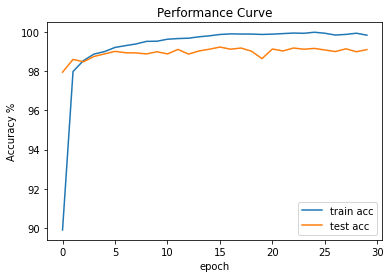

round: 1  total time used: 7.621362694104513
[1,  2000] loss:0.68630
[1,  4000] loss:0.14478
[1,  6000] loss:0.10619
epoch: 1 train accuary: 0.90105  test accuary: 0.9792
[2,  2000] loss:0.07880
[2,  4000] loss:0.07536
[2,  6000] loss:0.06863
epoch: 2 train accuary: 0.9765  test accuary: 0.9779
[3,  2000] loss:0.05601
[3,  4000] loss:0.05698
[3,  6000] loss:0.04585
epoch: 3 train accuary: 0.9833333333333333  test accuary: 0.9857
[4,  2000] loss:0.04351
[4,  4000] loss:0.03964
[4,  6000] loss:0.04074
epoch: 4 train accuary: 0.9869666666666667  test accuary: 0.9885
[5,  2000] loss:0.03044
[5,  4000] loss:0.03673
[5,  6000] loss:0.03423
epoch: 5 train accuary: 0.9889  test accuary: 0.9884
[6,  2000] loss:0.02782
[6,  4000] loss:0.02996
[6,  6000] loss:0.02934
epoch: 6 train accuary: 0.9908  test accuary: 0.9899
[7,  2000] loss:0.02128
[7,  4000] loss:0.02360
[7,  6000] loss:0.02513
epoch: 7 train accuary: 0.9930333333333333  test accuary: 0.9861
[8,  2000] loss:0.02053
[8,  4000] loss:0.0

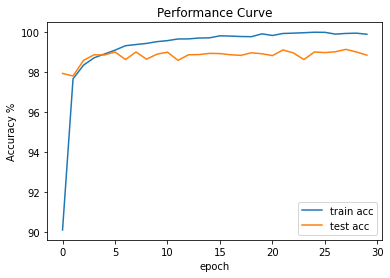

round: 2  total time used: 7.511788992087046
[1,  2000] loss:0.69441
[1,  4000] loss:0.14704
[1,  6000] loss:0.11119
epoch: 1 train accuary: 0.8967333333333334  test accuary: 0.9655
[2,  2000] loss:0.08956
[2,  4000] loss:0.07633
[2,  6000] loss:0.06553
epoch: 2 train accuary: 0.9757  test accuary: 0.9859
[3,  2000] loss:0.05563
[3,  4000] loss:0.05509
[3,  6000] loss:0.05327
epoch: 3 train accuary: 0.9825166666666667  test accuary: 0.9801
[4,  2000] loss:0.04273
[4,  4000] loss:0.04113
[4,  6000] loss:0.04005
epoch: 4 train accuary: 0.9871  test accuary: 0.987
[5,  2000] loss:0.03817
[5,  4000] loss:0.02822
[5,  6000] loss:0.03519
epoch: 5 train accuary: 0.98935  test accuary: 0.9891
[6,  2000] loss:0.02913
[6,  4000] loss:0.02781
[6,  6000] loss:0.02962
epoch: 6 train accuary: 0.9912666666666666  test accuary: 0.9913
[7,  2000] loss:0.02187
[7,  4000] loss:0.02669
[7,  6000] loss:0.02585
epoch: 7 train accuary: 0.9921333333333333  test accuary: 0.9879
[8,  2000] loss:0.02283
[8,  400

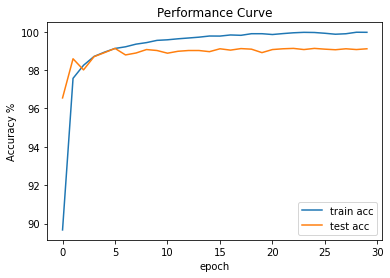

round: 3  total time used: 7.551182508468628
[1,  2000] loss:0.62778
[1,  4000] loss:0.14223
[1,  6000] loss:0.10259
epoch: 1 train accuary: 0.9115  test accuary: 0.9747
[2,  2000] loss:0.08155
[2,  4000] loss:0.07036
[2,  6000] loss:0.06894
epoch: 2 train accuary: 0.97695  test accuary: 0.9842
[3,  2000] loss:0.05453
[3,  4000] loss:0.05256
[3,  6000] loss:0.04847
epoch: 3 train accuary: 0.9840333333333333  test accuary: 0.9849
[4,  2000] loss:0.04077
[4,  4000] loss:0.03872
[4,  6000] loss:0.04188
epoch: 4 train accuary: 0.9873166666666666  test accuary: 0.9811
[5,  2000] loss:0.03366
[5,  4000] loss:0.03176
[5,  6000] loss:0.03122
epoch: 5 train accuary: 0.98935  test accuary: 0.9883
[6,  2000] loss:0.02737
[6,  4000] loss:0.02315
[6,  6000] loss:0.02905
epoch: 6 train accuary: 0.9916  test accuary: 0.9879
[7,  2000] loss:0.02219
[7,  4000] loss:0.02410
[7,  6000] loss:0.02331
epoch: 7 train accuary: 0.9922166666666666  test accuary: 0.9887
[8,  2000] loss:0.01621
[8,  4000] loss:0.

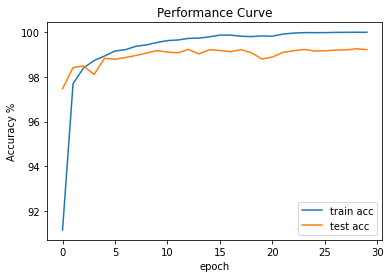

round: 4  total time used: 7.654575002193451
[1,  2000] loss:0.81067
[1,  4000] loss:0.13117
[1,  6000] loss:0.10301
epoch: 1 train accuary: 0.8900666666666667  test accuary: 0.9748
[2,  2000] loss:0.07295
[2,  4000] loss:0.07204
[2,  6000] loss:0.06018
epoch: 2 train accuary: 0.9790333333333333  test accuary: 0.9863
[3,  2000] loss:0.05359
[3,  4000] loss:0.04743
[3,  6000] loss:0.04546
epoch: 3 train accuary: 0.9847333333333333  test accuary: 0.9849
[4,  2000] loss:0.03837
[4,  4000] loss:0.03982
[4,  6000] loss:0.03677
epoch: 4 train accuary: 0.9884166666666667  test accuary: 0.9865
[5,  2000] loss:0.03117
[5,  4000] loss:0.03011
[5,  6000] loss:0.03102
epoch: 5 train accuary: 0.9902666666666666  test accuary: 0.9872
[6,  2000] loss:0.02726
[6,  4000] loss:0.02338
[6,  6000] loss:0.02777
epoch: 6 train accuary: 0.9919166666666667  test accuary: 0.9889
[7,  2000] loss:0.02044
[7,  4000] loss:0.02301
[7,  6000] loss:0.02069
epoch: 7 train accuary: 0.9933  test accuary: 0.9888
[8,  200

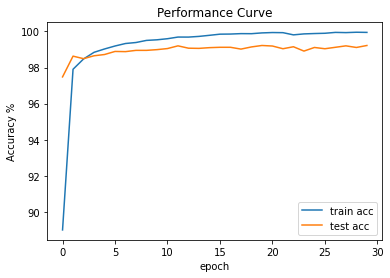

round: 5  total time used: 7.52466406027476
Best train accuracy among 5 runs: 99.99833333333333
Mean train accuracy among 5 runs: 99.922
Std train accuracy among 5 runs: 0.06394789545664277
Best test accuracy among 5 runs: 99.22
Mean test accuracy among 5 runs: 99.09400000000001
Std test accuracy among 5 runs: 0.14263239463740365


In [11]:
#good
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_MNIST_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.001
momentum=0.9
weight_decay=1e-5
meanTrainResults(1,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Data loaded
[1,  2000] loss:0.52355
[1,  4000] loss:0.10601
[1,  6000] loss:0.08751
epoch: 1 train accuary: 0.9232833333333333  test accuary: 0.9837
[2,  2000] loss:0.05972
[2,  4000] loss:0.05760
[2,  6000] loss:0.05925
epoch: 2 train accuary: 0.9818666666666667  test accuary: 0.9873
[3,  2000] loss:0.04249
[3,  4000] loss:0.04205
[3,  6000] loss:0.04323
epoch: 3 train accuary: 0.98655  test accuary: 0.9869
[4,  2000] loss:0.03322
[4,  4000] loss:0.03560
[4,  6000] loss:0.03271
epoch: 4 train accuary: 0.989  test accuary: 0.9875
[5,  2000] loss:0.02699
[5,  4000] loss:0.02814
[5,  6000] loss:0.02748
epoch: 5 train accuary: 0.9911333333333333  test accuary: 0.9892
[6,  2000] loss:0.02057
[6,  4000] loss:0.02170
[6,  6000] loss:0.02430
epoch: 6 train accuary: 0.9929666666666667  test accuary: 0.9882
[7,  2000] loss:0.01704
[7,  4000] loss:0.02086
[7,  6000] loss:0.01698
epoch: 7 train accuary: 0.9938833333333333  test accuary: 0.9905
[8,  2000] loss:0.01598
[8,  4000] loss:0.01784
[8,  

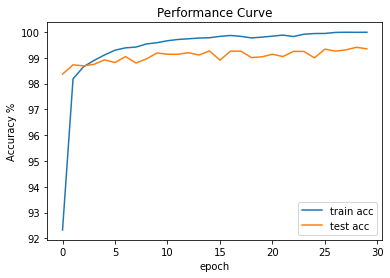

round: 1  total time used: 7.486436076958975
[1,  2000] loss:0.43651
[1,  4000] loss:0.10050
[1,  6000] loss:0.08471
epoch: 1 train accuary: 0.9335166666666667  test accuary: 0.9837
[2,  2000] loss:0.06219
[2,  4000] loss:0.05569
[2,  6000] loss:0.04584
epoch: 2 train accuary: 0.9828833333333333  test accuary: 0.9856
[3,  2000] loss:0.03611
[3,  4000] loss:0.04396
[3,  6000] loss:0.03609
epoch: 3 train accuary: 0.98825  test accuary: 0.9868
[4,  2000] loss:0.03211
[4,  4000] loss:0.02836
[4,  6000] loss:0.03003
epoch: 4 train accuary: 0.9907  test accuary: 0.9894
[5,  2000] loss:0.02342
[5,  4000] loss:0.02430
[5,  6000] loss:0.02507
epoch: 5 train accuary: 0.99255  test accuary: 0.9877
[6,  2000] loss:0.02001
[6,  4000] loss:0.01851
[6,  6000] loss:0.02217
epoch: 6 train accuary: 0.9937  test accuary: 0.9924
[7,  2000] loss:0.01423
[7,  4000] loss:0.01883
[7,  6000] loss:0.01968
epoch: 7 train accuary: 0.99415  test accuary: 0.9913
[8,  2000] loss:0.01479
[8,  4000] loss:0.01570
[8,  

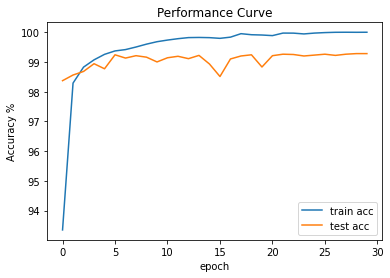

round: 2  total time used: 7.557373738288879
[1,  2000] loss:0.40539
[1,  4000] loss:0.11294
[1,  6000] loss:0.08542
epoch: 1 train accuary: 0.9354333333333333  test accuary: 0.975
[2,  2000] loss:0.06648
[2,  4000] loss:0.05663
[2,  6000] loss:0.05435
epoch: 2 train accuary: 0.9810666666666666  test accuary: 0.9777
[3,  2000] loss:0.04089
[3,  4000] loss:0.04469
[3,  6000] loss:0.04030
epoch: 3 train accuary: 0.9867166666666667  test accuary: 0.9881
[4,  2000] loss:0.03161
[4,  4000] loss:0.03086
[4,  6000] loss:0.03315
epoch: 4 train accuary: 0.9897666666666667  test accuary: 0.9897
[5,  2000] loss:0.02421
[5,  4000] loss:0.02468
[5,  6000] loss:0.02934
epoch: 5 train accuary: 0.9913833333333333  test accuary: 0.9861
[6,  2000] loss:0.01950
[6,  4000] loss:0.02099
[6,  6000] loss:0.02259
epoch: 6 train accuary: 0.9932833333333333  test accuary: 0.9902
[7,  2000] loss:0.01393
[7,  4000] loss:0.01784
[7,  6000] loss:0.02017
epoch: 7 train accuary: 0.9942333333333333  test accuary: 0.98

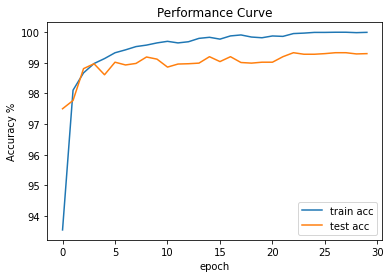

round: 3  total time used: 7.532213020324707
[1,  2000] loss:0.55680
[1,  4000] loss:0.12233
[1,  6000] loss:0.08843
epoch: 1 train accuary: 0.9177333333333333  test accuary: 0.9711
[2,  2000] loss:0.06564
[2,  4000] loss:0.05970
[2,  6000] loss:0.05718
epoch: 2 train accuary: 0.9808166666666667  test accuary: 0.9853
[3,  2000] loss:0.04198
[3,  4000] loss:0.04359
[3,  6000] loss:0.03921
epoch: 3 train accuary: 0.9868833333333333  test accuary: 0.9867
[4,  2000] loss:0.03010
[4,  4000] loss:0.03249
[4,  6000] loss:0.03590
epoch: 4 train accuary: 0.9899833333333333  test accuary: 0.9891
[5,  2000] loss:0.02308
[5,  4000] loss:0.02710
[5,  6000] loss:0.02781
epoch: 5 train accuary: 0.9915  test accuary: 0.9884
[6,  2000] loss:0.01831
[6,  4000] loss:0.02298
[6,  6000] loss:0.02353
epoch: 6 train accuary: 0.9929  test accuary: 0.9901
[7,  2000] loss:0.01774
[7,  4000] loss:0.01827
[7,  6000] loss:0.02002
epoch: 7 train accuary: 0.9939666666666667  test accuary: 0.9901
[8,  2000] loss:0.01

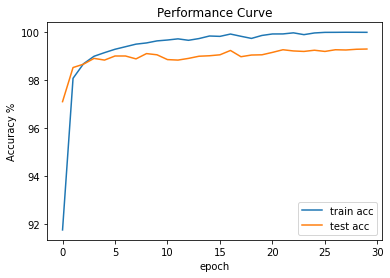

round: 4  total time used: 7.417631506919861
[1,  2000] loss:0.45908
[1,  4000] loss:0.10855
[1,  6000] loss:0.08447
epoch: 1 train accuary: 0.9315333333333333  test accuary: 0.982
[2,  2000] loss:0.05783
[2,  4000] loss:0.06149
[2,  6000] loss:0.05266
epoch: 2 train accuary: 0.98205  test accuary: 0.9837
[3,  2000] loss:0.03873
[3,  4000] loss:0.03796
[3,  6000] loss:0.04145
epoch: 3 train accuary: 0.98775  test accuary: 0.9887
[4,  2000] loss:0.02729
[4,  4000] loss:0.03373
[4,  6000] loss:0.03290
epoch: 4 train accuary: 0.99055  test accuary: 0.989
[5,  2000] loss:0.02345
[5,  4000] loss:0.02338
[5,  6000] loss:0.02569
epoch: 5 train accuary: 0.9922833333333333  test accuary: 0.9894
[6,  2000] loss:0.02016
[6,  4000] loss:0.02068
[6,  6000] loss:0.02193
epoch: 6 train accuary: 0.99305  test accuary: 0.9872
[7,  2000] loss:0.01622
[7,  4000] loss:0.01849
[7,  6000] loss:0.01834
epoch: 7 train accuary: 0.9946833333333334  test accuary: 0.9912
[8,  2000] loss:0.01445
[8,  4000] loss:0.

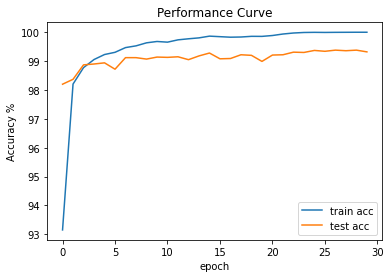

round: 5  total time used: 7.486725930372874
Best train accuracy among 5 runs: 100.0
Mean train accuracy among 5 runs: 99.99633333333334
Std train accuracy among 5 runs: 0.0024494897427809505
Best test accuracy among 5 runs: 99.35000000000001
Mean test accuracy among 5 runs: 99.31
Std test accuracy among 5 runs: 0.02366431913240096


In [12]:
#good
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_MNIST_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.01
momentum=0.5
weight_decay=1e-4
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Data loaded
[1,  2000] loss:0.31865
[1,  4000] loss:0.10537
[1,  6000] loss:0.08006
epoch: 1 train accuary: 0.9471333333333334  test accuary: 0.9718
[2,  2000] loss:0.06068
[2,  4000] loss:0.06262
[2,  6000] loss:0.05460
epoch: 2 train accuary: 0.9818833333333333  test accuary: 0.9833
[3,  2000] loss:0.04898
[3,  4000] loss:0.05032
[3,  6000] loss:0.04682
epoch: 3 train accuary: 0.9854  test accuary: 0.9874
[4,  2000] loss:0.03927
[4,  4000] loss:0.04191
[4,  6000] loss:0.04444
epoch: 4 train accuary: 0.9873166666666666  test accuary: 0.9851
[5,  2000] loss:0.03866
[5,  4000] loss:0.03829
[5,  6000] loss:0.03957
epoch: 5 train accuary: 0.9873833333333333  test accuary: 0.9875
[6,  2000] loss:0.03260
[6,  4000] loss:0.04132
[6,  6000] loss:0.03719
epoch: 6 train accuary: 0.9886  test accuary: 0.9856
[7,  2000] loss:0.03116
[7,  4000] loss:0.03439
[7,  6000] loss:0.03993
epoch: 7 train accuary: 0.9887666666666667  test accuary: 0.977
[8,  2000] loss:0.02748
[8,  4000] loss:0.03692
[8,  6

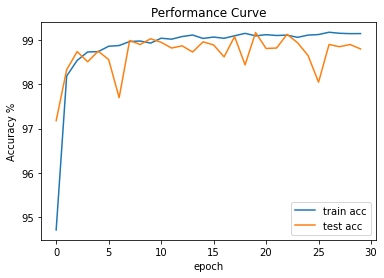

round: 1  total time used: 7.571846946080526
[1,  2000] loss:0.35444
[1,  4000] loss:0.10928
[1,  6000] loss:0.08724
epoch: 1 train accuary: 0.9412833333333334  test accuary: 0.98
[2,  2000] loss:0.07376
[2,  4000] loss:0.06325
[2,  6000] loss:0.06291
epoch: 2 train accuary: 0.9793666666666667  test accuary: 0.9845
[3,  2000] loss:0.05174
[3,  4000] loss:0.05149
[3,  6000] loss:0.05851
epoch: 3 train accuary: 0.9832833333333333  test accuary: 0.9783
[4,  2000] loss:0.04754
[4,  4000] loss:0.04861
[4,  6000] loss:0.04594
epoch: 4 train accuary: 0.9858833333333333  test accuary: 0.9869
[5,  2000] loss:0.04240
[5,  4000] loss:0.04545
[5,  6000] loss:0.04552
epoch: 5 train accuary: 0.9864833333333334  test accuary: 0.9844
[6,  2000] loss:0.04054
[6,  4000] loss:0.03919
[6,  6000] loss:0.04378
epoch: 6 train accuary: 0.9872833333333333  test accuary: 0.9826
[7,  2000] loss:0.03585
[7,  4000] loss:0.04235
[7,  6000] loss:0.03806
epoch: 7 train accuary: 0.9878333333333333  test accuary: 0.985

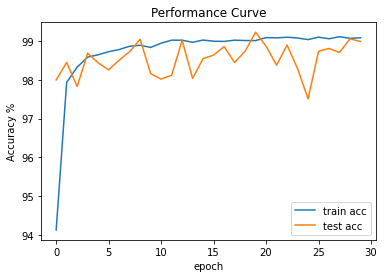

round: 2  total time used: 7.544929790496826
[1,  2000] loss:0.33663
[1,  4000] loss:0.09931
[1,  6000] loss:0.07659
epoch: 1 train accuary: 0.9461  test accuary: 0.9838
[2,  2000] loss:0.05884
[2,  4000] loss:0.06108
[2,  6000] loss:0.05936
epoch: 2 train accuary: 0.9824333333333334  test accuary: 0.9834
[3,  2000] loss:0.04812
[3,  4000] loss:0.04898
[3,  6000] loss:0.04836
epoch: 3 train accuary: 0.9847333333333333  test accuary: 0.9866
[4,  2000] loss:0.03748
[4,  4000] loss:0.04594
[4,  6000] loss:0.04702
epoch: 4 train accuary: 0.9871  test accuary: 0.9841
[5,  2000] loss:0.03446
[5,  4000] loss:0.04214
[5,  6000] loss:0.04138
epoch: 5 train accuary: 0.9876333333333334  test accuary: 0.9881
[6,  2000] loss:0.03523
[6,  4000] loss:0.04093
[6,  6000] loss:0.04166
epoch: 6 train accuary: 0.9876  test accuary: 0.9869
[7,  2000] loss:0.03557
[7,  4000] loss:0.03827
[7,  6000] loss:0.04087
epoch: 7 train accuary: 0.9882166666666666  test accuary: 0.9824
[8,  2000] loss:0.02980
[8,  400

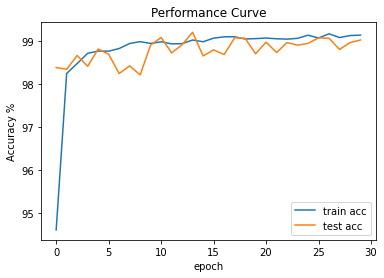

round: 3  total time used: 7.745473225911458
[1,  2000] loss:0.33956
[1,  4000] loss:0.09790
[1,  6000] loss:0.07989
epoch: 1 train accuary: 0.9439333333333333  test accuary: 0.9687
[2,  2000] loss:0.05917
[2,  4000] loss:0.05851
[2,  6000] loss:0.05658
epoch: 2 train accuary: 0.98235  test accuary: 0.9818
[3,  2000] loss:0.04448
[3,  4000] loss:0.04248
[3,  6000] loss:0.04853
epoch: 3 train accuary: 0.98595  test accuary: 0.9874
[4,  2000] loss:0.03741
[4,  4000] loss:0.04362
[4,  6000] loss:0.04231
epoch: 4 train accuary: 0.9875  test accuary: 0.9853
[5,  2000] loss:0.03674
[5,  4000] loss:0.03594
[5,  6000] loss:0.03816
epoch: 5 train accuary: 0.9882333333333333  test accuary: 0.9856
[6,  2000] loss:0.03329
[6,  4000] loss:0.03553
[6,  6000] loss:0.04014
epoch: 6 train accuary: 0.9887666666666667  test accuary: 0.9888
[7,  2000] loss:0.03140
[7,  4000] loss:0.03840
[7,  6000] loss:0.03534
epoch: 7 train accuary: 0.9894  test accuary: 0.9881
[8,  2000] loss:0.03206
[8,  4000] loss:0.

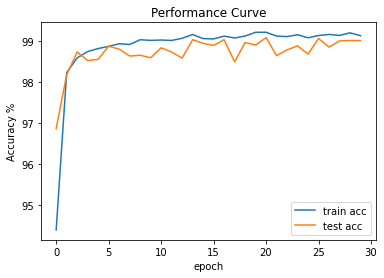

round: 4  total time used: 7.69635896285375
[1,  2000] loss:0.35200
[1,  4000] loss:0.10211
[1,  6000] loss:0.08154
epoch: 1 train accuary: 0.9424166666666667  test accuary: 0.9822
[2,  2000] loss:0.05969
[2,  4000] loss:0.05855
[2,  6000] loss:0.05927
epoch: 2 train accuary: 0.9817  test accuary: 0.9836
[3,  2000] loss:0.04314
[3,  4000] loss:0.04738
[3,  6000] loss:0.05037
epoch: 3 train accuary: 0.9857166666666667  test accuary: 0.987
[4,  2000] loss:0.03895
[4,  4000] loss:0.04355
[4,  6000] loss:0.04294
epoch: 4 train accuary: 0.98725  test accuary: 0.9869
[5,  2000] loss:0.03261
[5,  4000] loss:0.04556
[5,  6000] loss:0.04025
epoch: 5 train accuary: 0.9875  test accuary: 0.988
[6,  2000] loss:0.03395
[6,  4000] loss:0.03730
[6,  6000] loss:0.03947
epoch: 6 train accuary: 0.9886833333333334  test accuary: 0.9895
[7,  2000] loss:0.03369
[7,  4000] loss:0.03873
[7,  6000] loss:0.03572
epoch: 7 train accuary: 0.9888666666666667  test accuary: 0.9873
[8,  2000] loss:0.03551
[8,  4000]

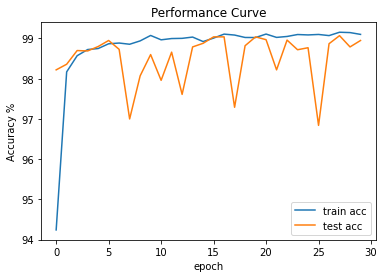

round: 5  total time used: 7.441962560017903
Best train accuracy among 5 runs: 99.14666666666668
Mean train accuracy among 5 runs: 99.12100000000001
Std train accuracy among 5 runs: 0.022842455598681387
Best test accuracy among 5 runs: 99.02
Mean test accuracy among 5 runs: 98.95599999999999
Std test accuracy among 5 runs: 0.08212186067059062


In [13]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_MNIST_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.005
momentum=0.9
weight_decay=1e-3
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Data loaded
[1,  2000] loss:0.58809
[1,  4000] loss:0.15586
[1,  6000] loss:0.11190
epoch: 1 train accuary: 0.9111333333333334  test accuary: 0.9752
[2,  2000] loss:0.08959
[2,  4000] loss:0.07454
[2,  6000] loss:0.06604
epoch: 2 train accuary: 0.9757333333333333  test accuary: 0.981
[3,  2000] loss:0.05381
[3,  4000] loss:0.05611
[3,  6000] loss:0.05001
epoch: 3 train accuary: 0.9829666666666667  test accuary: 0.9861
[4,  2000] loss:0.04552
[4,  4000] loss:0.04210
[4,  6000] loss:0.04387
epoch: 4 train accuary: 0.9861666666666666  test accuary: 0.9853
[5,  2000] loss:0.03691
[5,  4000] loss:0.03728
[5,  6000] loss:0.03801
epoch: 5 train accuary: 0.98825  test accuary: 0.9884
[6,  2000] loss:0.03173
[6,  4000] loss:0.03163
[6,  6000] loss:0.03363
epoch: 6 train accuary: 0.98965  test accuary: 0.9834
[7,  2000] loss:0.02581
[7,  4000] loss:0.03280
[7,  6000] loss:0.02721
epoch: 7 train accuary: 0.9909166666666667  test accuary: 0.9876
[8,  2000] loss:0.02176
[8,  4000] loss:0.02778
[8, 

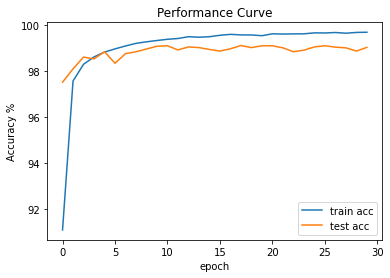

round: 1  total time used: 7.520049214363098
[1,  2000] loss:0.77035
[1,  4000] loss:0.14554
[1,  6000] loss:0.10408
epoch: 1 train accuary: 0.8926666666666667  test accuary: 0.9729
[2,  2000] loss:0.07306
[2,  4000] loss:0.07795
[2,  6000] loss:0.06449
epoch: 2 train accuary: 0.9773  test accuary: 0.9795
[3,  2000] loss:0.05274
[3,  4000] loss:0.05041
[3,  6000] loss:0.05118
epoch: 3 train accuary: 0.98385  test accuary: 0.9859
[4,  2000] loss:0.04091
[4,  4000] loss:0.04410
[4,  6000] loss:0.03785
epoch: 4 train accuary: 0.9869666666666667  test accuary: 0.9863
[5,  2000] loss:0.03127
[5,  4000] loss:0.03616
[5,  6000] loss:0.03524
epoch: 5 train accuary: 0.9892333333333333  test accuary: 0.9869
[6,  2000] loss:0.02899
[6,  4000] loss:0.02936
[6,  6000] loss:0.03284
epoch: 6 train accuary: 0.9903833333333333  test accuary: 0.9882
[7,  2000] loss:0.02645
[7,  4000] loss:0.02771
[7,  6000] loss:0.02610
epoch: 7 train accuary: 0.9915333333333334  test accuary: 0.989
[8,  2000] loss:0.02

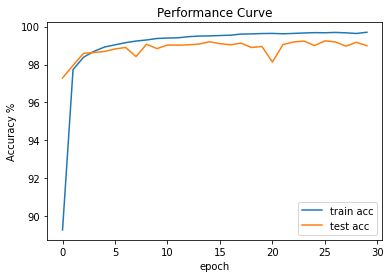

round: 2  total time used: 7.5704969684282934
[1,  2000] loss:0.63937
[1,  4000] loss:0.13170
[1,  6000] loss:0.09016
epoch: 1 train accuary: 0.9078  test accuary: 0.9794
[2,  2000] loss:0.07741
[2,  4000] loss:0.07063
[2,  6000] loss:0.06213
epoch: 2 train accuary: 0.9778166666666667  test accuary: 0.9843
[3,  2000] loss:0.05175
[3,  4000] loss:0.04927
[3,  6000] loss:0.05048
epoch: 3 train accuary: 0.9839333333333333  test accuary: 0.9865
[4,  2000] loss:0.03948
[4,  4000] loss:0.04329
[4,  6000] loss:0.04034
epoch: 4 train accuary: 0.9875166666666667  test accuary: 0.988
[5,  2000] loss:0.03178
[5,  4000] loss:0.03536
[5,  6000] loss:0.03791
epoch: 5 train accuary: 0.98885  test accuary: 0.9866
[6,  2000] loss:0.02666
[6,  4000] loss:0.03095
[6,  6000] loss:0.03372
epoch: 6 train accuary: 0.9904166666666666  test accuary: 0.9893
[7,  2000] loss:0.02719
[7,  4000] loss:0.02753
[7,  6000] loss:0.02753
epoch: 7 train accuary: 0.9913333333333333  test accuary: 0.9905
[8,  2000] loss:0.0

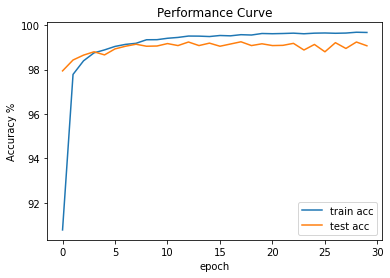

round: 3  total time used: 7.41265911658605
[1,  2000] loss:0.63938
[1,  4000] loss:0.16011
[1,  6000] loss:0.10939
epoch: 1 train accuary: 0.9044333333333333  test accuary: 0.9728
[2,  2000] loss:0.08949
[2,  4000] loss:0.08093
[2,  6000] loss:0.07006
epoch: 2 train accuary: 0.974  test accuary: 0.9828
[3,  2000] loss:0.06129
[3,  4000] loss:0.05881
[3,  6000] loss:0.05360
epoch: 3 train accuary: 0.9819333333333333  test accuary: 0.9823
[4,  2000] loss:0.04523
[4,  4000] loss:0.04693
[4,  6000] loss:0.04794
epoch: 4 train accuary: 0.9851  test accuary: 0.9876
[5,  2000] loss:0.03751
[5,  4000] loss:0.03957
[5,  6000] loss:0.03905
epoch: 5 train accuary: 0.9876166666666667  test accuary: 0.9901
[6,  2000] loss:0.03170
[6,  4000] loss:0.03597
[6,  6000] loss:0.03257
epoch: 6 train accuary: 0.9890166666666667  test accuary: 0.9867
[7,  2000] loss:0.02992
[7,  4000] loss:0.02835
[7,  6000] loss:0.03369
epoch: 7 train accuary: 0.9901  test accuary: 0.988
[8,  2000] loss:0.02556
[8,  4000] 

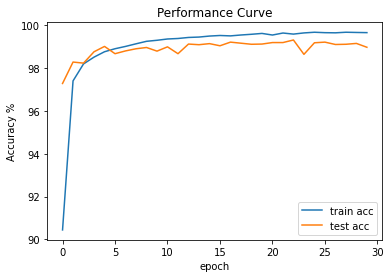

round: 4  total time used: 7.399403738975525
[1,  2000] loss:0.59148
[1,  4000] loss:0.14016
[1,  6000] loss:0.10381
epoch: 1 train accuary: 0.9122833333333333  test accuary: 0.976
[2,  2000] loss:0.08387
[2,  4000] loss:0.07583
[2,  6000] loss:0.06759
epoch: 2 train accuary: 0.9762833333333333  test accuary: 0.9836
[3,  2000] loss:0.05421
[3,  4000] loss:0.05589
[3,  6000] loss:0.05355
epoch: 3 train accuary: 0.98255  test accuary: 0.9834
[4,  2000] loss:0.04473
[4,  4000] loss:0.03900
[4,  6000] loss:0.04708
epoch: 4 train accuary: 0.9862333333333333  test accuary: 0.9888
[5,  2000] loss:0.03363
[5,  4000] loss:0.03989
[5,  6000] loss:0.03509
epoch: 5 train accuary: 0.98855  test accuary: 0.9883
[6,  2000] loss:0.03332
[6,  4000] loss:0.02973
[6,  6000] loss:0.03366
epoch: 6 train accuary: 0.9901  test accuary: 0.9888
[7,  2000] loss:0.02770
[7,  4000] loss:0.02975
[7,  6000] loss:0.02805
epoch: 7 train accuary: 0.9911333333333333  test accuary: 0.9915
[8,  2000] loss:0.02294
[8,  40

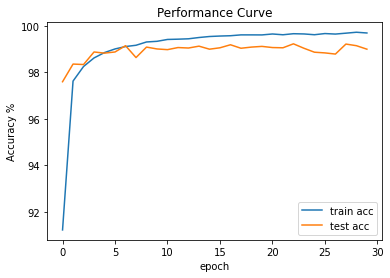

round: 5  total time used: 7.333376701672872
Best train accuracy among 5 runs: 99.70333333333333
Mean train accuracy among 5 runs: 99.682
Std train accuracy among 5 runs: 0.018208667044996765
Best test accuracy among 5 runs: 99.07000000000001
Mean test accuracy among 5 runs: 99.01199999999999
Std test accuracy among 5 runs: 0.03487119154832888


In [14]:
#good
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_MNIST_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.005
momentum=0.5
weight_decay=1e-3
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Data loaded
[1,  2000] loss:1.37100
[1,  4000] loss:0.22448
[1,  6000] loss:0.14934
epoch: 1 train accuary: 0.8127  test accuary: 0.9633
[2,  2000] loss:0.10565
[2,  4000] loss:0.09184
[2,  6000] loss:0.08279
epoch: 2 train accuary: 0.9714  test accuary: 0.9797
[3,  2000] loss:0.07052
[3,  4000] loss:0.06462
[3,  6000] loss:0.06183
epoch: 3 train accuary: 0.9789333333333333  test accuary: 0.9835
[4,  2000] loss:0.05254
[4,  4000] loss:0.05264
[4,  6000] loss:0.04842
epoch: 4 train accuary: 0.9841166666666666  test accuary: 0.9848
[5,  2000] loss:0.04393
[5,  4000] loss:0.04335
[5,  6000] loss:0.04187
epoch: 5 train accuary: 0.9866166666666667  test accuary: 0.9858
[6,  2000] loss:0.03638
[6,  4000] loss:0.03923
[6,  6000] loss:0.03459
epoch: 6 train accuary: 0.9884  test accuary: 0.986
[7,  2000] loss:0.03202
[7,  4000] loss:0.03310
[7,  6000] loss:0.03352
epoch: 7 train accuary: 0.9894166666666667  test accuary: 0.989
[8,  2000] loss:0.02781
[8,  4000] loss:0.03001
[8,  6000] loss:0.0

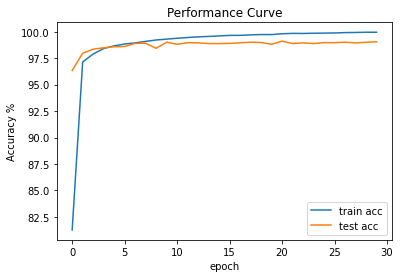

round: 1  total time used: 8.374451871713003
[1,  2000] loss:1.10863
[1,  4000] loss:0.19464
[1,  6000] loss:0.12697
epoch: 1 train accuary: 0.84055  test accuary: 0.9696
[2,  2000] loss:0.09977
[2,  4000] loss:0.09386
[2,  6000] loss:0.08130
epoch: 2 train accuary: 0.9719333333333333  test accuary: 0.9777
[3,  2000] loss:0.06410
[3,  4000] loss:0.06536
[3,  6000] loss:0.06558
epoch: 3 train accuary: 0.9797166666666667  test accuary: 0.9834
[4,  2000] loss:0.04871
[4,  4000] loss:0.06069
[4,  6000] loss:0.05007
epoch: 4 train accuary: 0.9836  test accuary: 0.9875
[5,  2000] loss:0.04125
[5,  4000] loss:0.04513
[5,  6000] loss:0.04411
epoch: 5 train accuary: 0.98665  test accuary: 0.987
[6,  2000] loss:0.03654
[6,  4000] loss:0.03534
[6,  6000] loss:0.03949
epoch: 6 train accuary: 0.9883333333333333  test accuary: 0.9883
[7,  2000] loss:0.02995
[7,  4000] loss:0.03371
[7,  6000] loss:0.03386
epoch: 7 train accuary: 0.9896333333333334  test accuary: 0.9893
[8,  2000] loss:0.02983
[8,  40

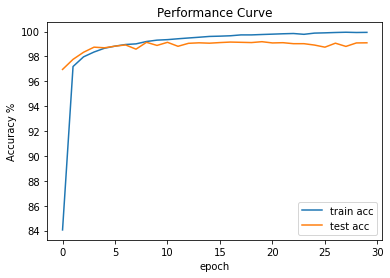

round: 2  total time used: 11.267428318659464
[1,  2000] loss:1.09132
[1,  4000] loss:0.20402
[1,  6000] loss:0.12967
epoch: 1 train accuary: 0.8515  test accuary: 0.973
[2,  2000] loss:0.10728
[2,  4000] loss:0.08699
[2,  6000] loss:0.07759
epoch: 2 train accuary: 0.9718333333333333  test accuary: 0.9805
[3,  2000] loss:0.07177
[3,  4000] loss:0.06095
[3,  6000] loss:0.06321
epoch: 3 train accuary: 0.9796166666666667  test accuary: 0.9834
[4,  2000] loss:0.05040
[4,  4000] loss:0.05414
[4,  6000] loss:0.04877
epoch: 4 train accuary: 0.9842666666666666  test accuary: 0.9871
[5,  2000] loss:0.04476
[5,  4000] loss:0.04206
[5,  6000] loss:0.04235
epoch: 5 train accuary: 0.9867166666666667  test accuary: 0.984
[6,  2000] loss:0.03897
[6,  4000] loss:0.03915
[6,  6000] loss:0.03129
epoch: 6 train accuary: 0.9887166666666667  test accuary: 0.9878
[7,  2000] loss:0.03180
[7,  4000] loss:0.03312
[7,  6000] loss:0.03179
epoch: 7 train accuary: 0.9895  test accuary: 0.9892
[8,  2000] loss:0.026

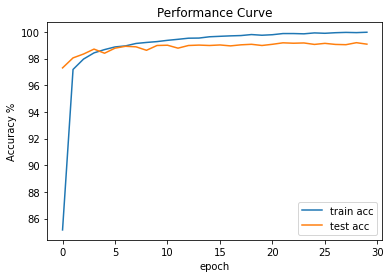

round: 3  total time used: 7.699453568458557
[1,  2000] loss:1.13268
[1,  4000] loss:0.26931
[1,  6000] loss:0.15146
epoch: 1 train accuary: 0.8302  test accuary: 0.9687
[2,  2000] loss:0.12114
[2,  4000] loss:0.09290
[2,  6000] loss:0.08293
epoch: 2 train accuary: 0.9697166666666667  test accuary: 0.9801
[3,  2000] loss:0.06962
[3,  4000] loss:0.06358
[3,  6000] loss:0.06486
epoch: 3 train accuary: 0.97925  test accuary: 0.9853
[4,  2000] loss:0.05579
[4,  4000] loss:0.05257
[4,  6000] loss:0.04893
epoch: 4 train accuary: 0.9836333333333334  test accuary: 0.9874
[5,  2000] loss:0.04588
[5,  4000] loss:0.04041
[5,  6000] loss:0.04279
epoch: 5 train accuary: 0.98635  test accuary: 0.9864
[6,  2000] loss:0.03582
[6,  4000] loss:0.03955
[6,  6000] loss:0.03643
epoch: 6 train accuary: 0.9884166666666667  test accuary: 0.9887
[7,  2000] loss:0.03160
[7,  4000] loss:0.02982
[7,  6000] loss:0.03454
epoch: 7 train accuary: 0.9897833333333333  test accuary: 0.9877
[8,  2000] loss:0.02464
[8,  4

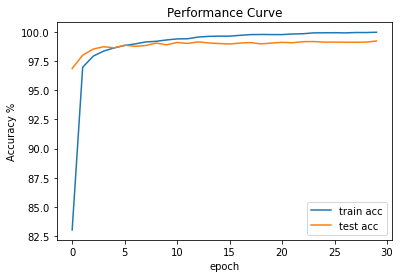

round: 4  total time used: 7.2964729030927025
[1,  2000] loss:1.07605
[1,  4000] loss:0.23985
[1,  6000] loss:0.13928
epoch: 1 train accuary: 0.84345  test accuary: 0.9674
[2,  2000] loss:0.11319
[2,  4000] loss:0.09592
[2,  6000] loss:0.08591
epoch: 2 train accuary: 0.9697166666666667  test accuary: 0.9747
[3,  2000] loss:0.07467
[3,  4000] loss:0.06924
[3,  6000] loss:0.06606
epoch: 3 train accuary: 0.97815  test accuary: 0.9827
[4,  2000] loss:0.05970
[4,  4000] loss:0.05257
[4,  6000] loss:0.05309
epoch: 4 train accuary: 0.9823333333333333  test accuary: 0.9851
[5,  2000] loss:0.04812
[5,  4000] loss:0.04418
[5,  6000] loss:0.04330
epoch: 5 train accuary: 0.9858666666666667  test accuary: 0.9828
[6,  2000] loss:0.03952
[6,  4000] loss:0.04145
[6,  6000] loss:0.03505
epoch: 6 train accuary: 0.9881333333333333  test accuary: 0.9852
[7,  2000] loss:0.03605
[7,  4000] loss:0.03261
[7,  6000] loss:0.03319
epoch: 7 train accuary: 0.9891  test accuary: 0.9887
[8,  2000] loss:0.02922
[8,  

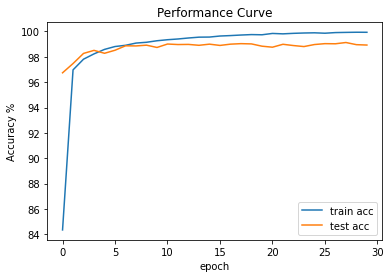

round: 5  total time used: 7.351755658785502
Best train accuracy among 5 runs: 99.97833333333334
Mean train accuracy among 5 runs: 99.95566666666667
Std train accuracy among 5 runs: 0.01711399687065857
Best test accuracy among 5 runs: 99.22999999999999
Mean test accuracy among 5 runs: 99.078
Std test accuracy among 5 runs: 0.09620810776644366


In [15]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_MNIST_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.0005
momentum=0.9
weight_decay=1e-5
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


In [16]:
##Fashion Data

Data loaded
[1,  2000] loss:1.06501
[1,  4000] loss:0.60453
[1,  6000] loss:0.49065
epoch: 1 train accuary: 0.7305666666666667  test accuary: 0.8249
[2,  2000] loss:0.42981
[2,  4000] loss:0.40450
[2,  6000] loss:0.37398
epoch: 2 train accuary: 0.85225  test accuary: 0.8638
[3,  2000] loss:0.35590
[3,  4000] loss:0.32699
[3,  6000] loss:0.33736
epoch: 3 train accuary: 0.87565  test accuary: 0.8709
[4,  2000] loss:0.31102
[4,  4000] loss:0.29742
[4,  6000] loss:0.30382
epoch: 4 train accuary: 0.8867833333333334  test accuary: 0.8838
[5,  2000] loss:0.28079
[5,  4000] loss:0.27632
[5,  6000] loss:0.28802
epoch: 5 train accuary: 0.8967166666666667  test accuary: 0.8868
[6,  2000] loss:0.27071
[6,  4000] loss:0.25831
[6,  6000] loss:0.26467
epoch: 6 train accuary: 0.9026166666666666  test accuary: 0.8936
[7,  2000] loss:0.24774
[7,  4000] loss:0.25223
[7,  6000] loss:0.24666
epoch: 7 train accuary: 0.9080166666666667  test accuary: 0.8903
[8,  2000] loss:0.23965
[8,  4000] loss:0.23732
[8,

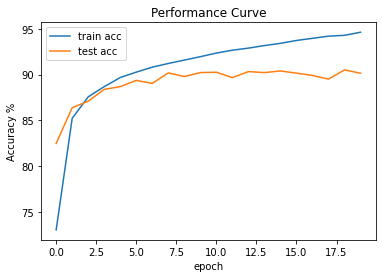

round: 1  total time used: 4.837476273377736
[1,  2000] loss:1.20810
[1,  4000] loss:0.54876
[1,  6000] loss:0.45786
epoch: 1 train accuary: 0.7208166666666667  test accuary: 0.8388
[2,  2000] loss:0.40282
[2,  4000] loss:0.37738
[2,  6000] loss:0.35840
epoch: 2 train accuary: 0.8618666666666667  test accuary: 0.8506
[3,  2000] loss:0.33966
[3,  4000] loss:0.31663
[3,  6000] loss:0.31900
epoch: 3 train accuary: 0.8789833333333333  test accuary: 0.878
[4,  2000] loss:0.30100
[4,  4000] loss:0.29756
[4,  6000] loss:0.29234
epoch: 4 train accuary: 0.8893  test accuary: 0.8869
[5,  2000] loss:0.28121
[5,  4000] loss:0.27229
[5,  6000] loss:0.27253
epoch: 5 train accuary: 0.8983666666666666  test accuary: 0.8776
[6,  2000] loss:0.25358
[6,  4000] loss:0.25889
[6,  6000] loss:0.26456
epoch: 6 train accuary: 0.9028166666666667  test accuary: 0.889
[7,  2000] loss:0.24445
[7,  4000] loss:0.25210
[7,  6000] loss:0.24671
epoch: 7 train accuary: 0.9086166666666666  test accuary: 0.8879
[8,  2000]

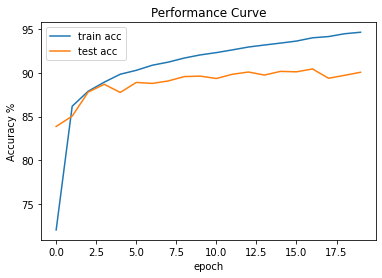

round: 2  total time used: 4.841627748807271
[1,  2000] loss:1.02996
[1,  4000] loss:0.56717
[1,  6000] loss:0.47198
epoch: 1 train accuary: 0.74385  test accuary: 0.833
[2,  2000] loss:0.41236
[2,  4000] loss:0.39639
[2,  6000] loss:0.36213
epoch: 2 train accuary: 0.85575  test accuary: 0.8683
[3,  2000] loss:0.33720
[3,  4000] loss:0.34775
[3,  6000] loss:0.31266
epoch: 3 train accuary: 0.87785  test accuary: 0.8781
[4,  2000] loss:0.29785
[4,  4000] loss:0.29736
[4,  6000] loss:0.30478
epoch: 4 train accuary: 0.8883166666666666  test accuary: 0.8752
[5,  2000] loss:0.28322
[5,  4000] loss:0.28043
[5,  6000] loss:0.27083
epoch: 5 train accuary: 0.89655  test accuary: 0.8864
[6,  2000] loss:0.26248
[6,  4000] loss:0.25858
[6,  6000] loss:0.26470
epoch: 6 train accuary: 0.9023  test accuary: 0.8858
[7,  2000] loss:0.24376
[7,  4000] loss:0.24800
[7,  6000] loss:0.25088
epoch: 7 train accuary: 0.9079166666666667  test accuary: 0.8953
[8,  2000] loss:0.23460
[8,  4000] loss:0.23959
[8,  

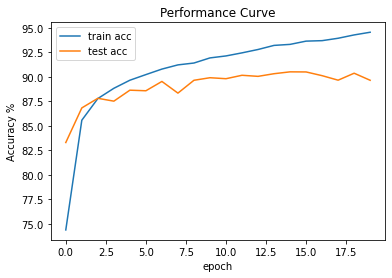

round: 3  total time used: 4.838143165906271
[1,  2000] loss:1.14019
[1,  4000] loss:0.56104
[1,  6000] loss:0.46287
epoch: 1 train accuary: 0.7351166666666666  test accuary: 0.8355
[2,  2000] loss:0.41892
[2,  4000] loss:0.39062
[2,  6000] loss:0.35969
epoch: 2 train accuary: 0.8561833333333333  test accuary: 0.8643
[3,  2000] loss:0.33990
[3,  4000] loss:0.33002
[3,  6000] loss:0.32143
epoch: 3 train accuary: 0.8770166666666667  test accuary: 0.8765
[4,  2000] loss:0.30214
[4,  4000] loss:0.30176
[4,  6000] loss:0.29202
epoch: 4 train accuary: 0.8891  test accuary: 0.888
[5,  2000] loss:0.28622
[5,  4000] loss:0.27621
[5,  6000] loss:0.27200
epoch: 5 train accuary: 0.8954166666666666  test accuary: 0.8885
[6,  2000] loss:0.26145
[6,  4000] loss:0.25608
[6,  6000] loss:0.26108
epoch: 6 train accuary: 0.9023166666666667  test accuary: 0.8935
[7,  2000] loss:0.24740
[7,  4000] loss:0.25136
[7,  6000] loss:0.24716
epoch: 7 train accuary: 0.9062666666666667  test accuary: 0.8956
[8,  2000

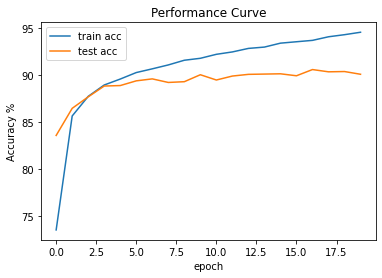

round: 4  total time used: 4.84831794500351
[1,  2000] loss:1.02433
[1,  4000] loss:0.55052
[1,  6000] loss:0.46043
epoch: 1 train accuary: 0.7512333333333333  test accuary: 0.8381
[2,  2000] loss:0.41673
[2,  4000] loss:0.38038
[2,  6000] loss:0.36939
epoch: 2 train accuary: 0.8596833333333334  test accuary: 0.8631
[3,  2000] loss:0.34454
[3,  4000] loss:0.33125
[3,  6000] loss:0.32122
epoch: 3 train accuary: 0.8797833333333334  test accuary: 0.8772
[4,  2000] loss:0.30690
[4,  4000] loss:0.30616
[4,  6000] loss:0.29336
epoch: 4 train accuary: 0.8907333333333334  test accuary: 0.8715
[5,  2000] loss:0.28235
[5,  4000] loss:0.27876
[5,  6000] loss:0.27959
epoch: 5 train accuary: 0.8972  test accuary: 0.8895
[6,  2000] loss:0.26359
[6,  4000] loss:0.26397
[6,  6000] loss:0.26248
epoch: 6 train accuary: 0.9019666666666667  test accuary: 0.8901
[7,  2000] loss:0.25069
[7,  4000] loss:0.24990
[7,  6000] loss:0.24653
epoch: 7 train accuary: 0.9073666666666667  test accuary: 0.8927
[8,  2000

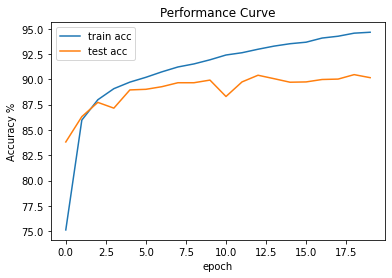

round: 5  total time used: 4.855676078796387
Best train accuracy among 5 runs: 94.64666666666666
Mean train accuracy among 5 runs: 94.58933333333333
Std train accuracy among 5 runs: 0.04910985418200379
Best test accuracy among 5 runs: 90.16
Mean test accuracy among 5 runs: 90.01199999999999
Std test accuracy among 5 runs: 0.1860537556729266


In [17]:
#good
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_Fashion_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=20
learning_rate=0.001
momentum=0.9
weight_decay=1e-5
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Data loaded
[1,  2000] loss:1.05132
[1,  4000] loss:0.58128
[1,  6000] loss:0.47799
epoch: 1 train accuary: 0.7395333333333334  test accuary: 0.824
[2,  2000] loss:0.42504
[2,  4000] loss:0.39681
[2,  6000] loss:0.36832
epoch: 2 train accuary: 0.8545333333333334  test accuary: 0.8585
[3,  2000] loss:0.35402
[3,  4000] loss:0.33661
[3,  6000] loss:0.32406
epoch: 3 train accuary: 0.87525  test accuary: 0.8773
[4,  2000] loss:0.31072
[4,  4000] loss:0.30738
[4,  6000] loss:0.29450
epoch: 4 train accuary: 0.8880166666666667  test accuary: 0.8792
[5,  2000] loss:0.28074
[5,  4000] loss:0.28703
[5,  6000] loss:0.28262
epoch: 5 train accuary: 0.8962666666666667  test accuary: 0.8945
[6,  2000] loss:0.26331
[6,  4000] loss:0.26520
[6,  6000] loss:0.26501
epoch: 6 train accuary: 0.9023166666666667  test accuary: 0.8954
[7,  2000] loss:0.24951
[7,  4000] loss:0.25001
[7,  6000] loss:0.25024
epoch: 7 train accuary: 0.9081  test accuary: 0.8892
[8,  2000] loss:0.23454
[8,  4000] loss:0.23509
[8,  

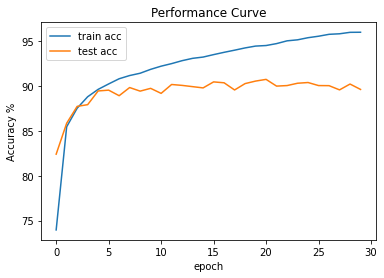

round: 1  total time used: 7.2642947912216185
[1,  2000] loss:1.08332
[1,  4000] loss:0.54064
[1,  6000] loss:0.45567
epoch: 1 train accuary: 0.7431333333333333  test accuary: 0.8215
[2,  2000] loss:0.40151
[2,  4000] loss:0.37420
[2,  6000] loss:0.34356
epoch: 2 train accuary: 0.8637  test accuary: 0.8682
[3,  2000] loss:0.32847
[3,  4000] loss:0.31258
[3,  6000] loss:0.31231
epoch: 3 train accuary: 0.8836333333333334  test accuary: 0.8753
[4,  2000] loss:0.29099
[4,  4000] loss:0.29691
[4,  6000] loss:0.28400
epoch: 4 train accuary: 0.89385  test accuary: 0.8695
[5,  2000] loss:0.27468
[5,  4000] loss:0.26521
[5,  6000] loss:0.27349
epoch: 5 train accuary: 0.9003666666666666  test accuary: 0.8822
[6,  2000] loss:0.24509
[6,  4000] loss:0.26044
[6,  6000] loss:0.25921
epoch: 6 train accuary: 0.90515  test accuary: 0.8851
[7,  2000] loss:0.24044
[7,  4000] loss:0.23873
[7,  6000] loss:0.24206
epoch: 7 train accuary: 0.9104333333333333  test accuary: 0.8951
[8,  2000] loss:0.22898
[8,  

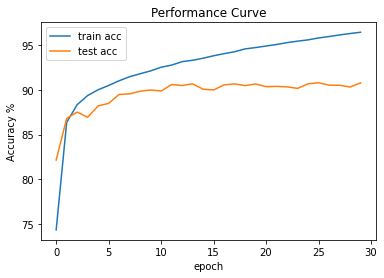

round: 2  total time used: 7.257155474026998
[1,  2000] loss:0.95658
[1,  4000] loss:0.54674
[1,  6000] loss:0.46600
epoch: 1 train accuary: 0.7584166666666666  test accuary: 0.848
[2,  2000] loss:0.41268
[2,  4000] loss:0.38529
[2,  6000] loss:0.36197
epoch: 2 train accuary: 0.85765  test accuary: 0.8557
[3,  2000] loss:0.34399
[3,  4000] loss:0.33296
[3,  6000] loss:0.30982
epoch: 3 train accuary: 0.8793666666666666  test accuary: 0.8741
[4,  2000] loss:0.29605
[4,  4000] loss:0.30145
[4,  6000] loss:0.29596
epoch: 4 train accuary: 0.8905166666666666  test accuary: 0.8769
[5,  2000] loss:0.27397
[5,  4000] loss:0.27428
[5,  6000] loss:0.27720
epoch: 5 train accuary: 0.8968666666666667  test accuary: 0.891
[6,  2000] loss:0.25871
[6,  4000] loss:0.26138
[6,  6000] loss:0.25428
epoch: 6 train accuary: 0.9032  test accuary: 0.8955
[7,  2000] loss:0.24268
[7,  4000] loss:0.24059
[7,  6000] loss:0.24627
epoch: 7 train accuary: 0.9093333333333333  test accuary: 0.8952
[8,  2000] loss:0.232

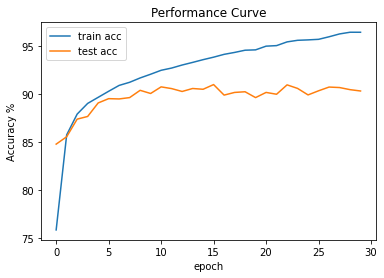

round: 3  total time used: 7.265477534135183
[1,  2000] loss:1.04225
[1,  4000] loss:0.56254
[1,  6000] loss:0.47782
epoch: 1 train accuary: 0.7437333333333334  test accuary: 0.8207
[2,  2000] loss:0.40669
[2,  4000] loss:0.38145
[2,  6000] loss:0.36311
epoch: 2 train accuary: 0.8590833333333333  test accuary: 0.8696
[3,  2000] loss:0.34129
[3,  4000] loss:0.32363
[3,  6000] loss:0.31591
epoch: 3 train accuary: 0.8809666666666667  test accuary: 0.8692
[4,  2000] loss:0.30199
[4,  4000] loss:0.29322
[4,  6000] loss:0.28920
epoch: 4 train accuary: 0.8913166666666666  test accuary: 0.8843
[5,  2000] loss:0.27776
[5,  4000] loss:0.26926
[5,  6000] loss:0.27575
epoch: 5 train accuary: 0.8989666666666667  test accuary: 0.8888
[6,  2000] loss:0.26224
[6,  4000] loss:0.26553
[6,  6000] loss:0.24916
epoch: 6 train accuary: 0.9019166666666667  test accuary: 0.8816
[7,  2000] loss:0.24372
[7,  4000] loss:0.24470
[7,  6000] loss:0.24686
epoch: 7 train accuary: 0.9080166666666667  test accuary: 0.8

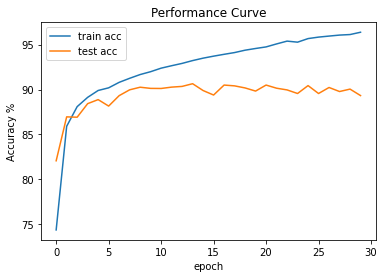

round: 4  total time used: 7.254627549648285
[1,  2000] loss:1.10628
[1,  4000] loss:0.53172
[1,  6000] loss:0.44188
epoch: 1 train accuary: 0.7460166666666667  test accuary: 0.841
[2,  2000] loss:0.39765
[2,  4000] loss:0.37751
[2,  6000] loss:0.35430
epoch: 2 train accuary: 0.8621  test accuary: 0.8617
[3,  2000] loss:0.32258
[3,  4000] loss:0.32553
[3,  6000] loss:0.30834
epoch: 3 train accuary: 0.8829333333333333  test accuary: 0.8845
[4,  2000] loss:0.30170
[4,  4000] loss:0.28346
[4,  6000] loss:0.28714
epoch: 4 train accuary: 0.89285  test accuary: 0.883
[5,  2000] loss:0.26554
[5,  4000] loss:0.27185
[5,  6000] loss:0.27057
epoch: 5 train accuary: 0.9001666666666667  test accuary: 0.8959
[6,  2000] loss:0.25110
[6,  4000] loss:0.25711
[6,  6000] loss:0.24929
epoch: 6 train accuary: 0.90705  test accuary: 0.8895
[7,  2000] loss:0.23093
[7,  4000] loss:0.24078
[7,  6000] loss:0.24848
epoch: 7 train accuary: 0.9117333333333333  test accuary: 0.8961
[8,  2000] loss:0.22589
[8,  400

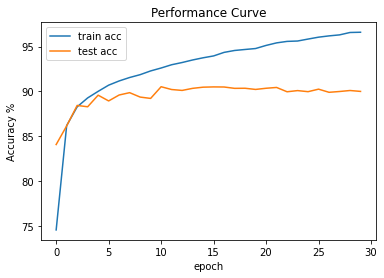

round: 5  total time used: 7.23068102200826
Best train accuracy among 5 runs: 96.59166666666667
Mean train accuracy among 5 runs: 96.38733333333334
Std train accuracy among 5 runs: 0.20648540438060492
Best test accuracy among 5 runs: 90.8
Mean test accuracy among 5 runs: 90.02199999999999
Std test accuracy among 5 runs: 0.5202845375369117


In [18]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_Fashion_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.001
momentum=0.9
weight_decay=1e-5
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Data loaded
[1,  2000] loss:0.64762
epoch: 1 train accuary: 0.8043833333333333  test accuary: 0.8694
[2,  2000] loss:0.34659
epoch: 2 train accuary: 0.8760833333333333  test accuary: 0.8819
[3,  2000] loss:0.30318
epoch: 3 train accuary: 0.8879333333333334  test accuary: 0.8844
[4,  2000] loss:0.27507
epoch: 4 train accuary: 0.8959666666666667  test accuary: 0.888
[5,  2000] loss:0.25538
epoch: 5 train accuary: 0.90415  test accuary: 0.8729
[6,  2000] loss:0.24432
epoch: 6 train accuary: 0.9069166666666667  test accuary: 0.8833
[7,  2000] loss:0.23261
epoch: 7 train accuary: 0.91165  test accuary: 0.8918
[8,  2000] loss:0.21922
epoch: 8 train accuary: 0.9153666666666667  test accuary: 0.8935
[9,  2000] loss:0.21255
epoch: 9 train accuary: 0.9188833333333334  test accuary: 0.8972
[10,  2000] loss:0.19529
epoch: 10 train accuary: 0.9223333333333333  test accuary: 0.9009
[11,  2000] loss:0.19488
epoch: 11 train accuary: 0.9257666666666666  test accuary: 0.8985
[12,  2000] loss:0.18661
epo

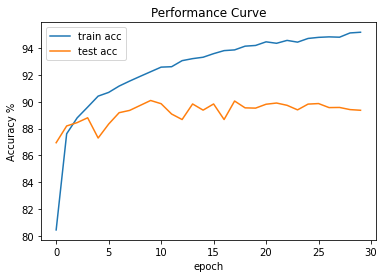

round: 1  total time used: 5.320559211572012
[1,  2000] loss:0.67536
epoch: 1 train accuary: 0.80095  test accuary: 0.8522
[2,  2000] loss:0.33636
epoch: 2 train accuary: 0.8779833333333333  test accuary: 0.8765
[3,  2000] loss:0.29425
epoch: 3 train accuary: 0.8915166666666666  test accuary: 0.8893
[4,  2000] loss:0.27322
epoch: 4 train accuary: 0.9001166666666667  test accuary: 0.8964
[5,  2000] loss:0.25508
epoch: 5 train accuary: 0.9063  test accuary: 0.8893
[6,  2000] loss:0.24067
epoch: 6 train accuary: 0.9094166666666667  test accuary: 0.8991
[7,  2000] loss:0.22391
epoch: 7 train accuary: 0.9145166666666666  test accuary: 0.8966
[8,  2000] loss:0.21173
epoch: 8 train accuary: 0.9174833333333333  test accuary: 0.8921
[9,  2000] loss:0.20152
epoch: 9 train accuary: 0.9210166666666667  test accuary: 0.9049
[10,  2000] loss:0.19715
epoch: 10 train accuary: 0.9244  test accuary: 0.8969
[11,  2000] loss:0.18647
epoch: 11 train accuary: 0.9264166666666667  test accuary: 0.8973
[12,  2

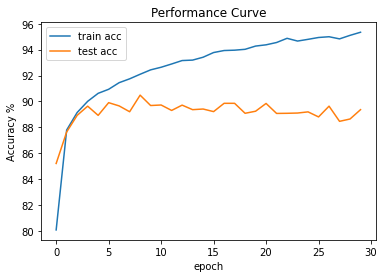

round: 2  total time used: 5.263131658236186
[1,  2000] loss:0.66301
epoch: 1 train accuary: 0.8003666666666667  test accuary: 0.8476
[2,  2000] loss:0.34311
epoch: 2 train accuary: 0.8754333333333333  test accuary: 0.87
[3,  2000] loss:0.30125
epoch: 3 train accuary: 0.8879666666666667  test accuary: 0.8688
[4,  2000] loss:0.27332
epoch: 4 train accuary: 0.89595  test accuary: 0.8737
[5,  2000] loss:0.25711
epoch: 5 train accuary: 0.9021666666666667  test accuary: 0.8879
[6,  2000] loss:0.24074
epoch: 6 train accuary: 0.9062  test accuary: 0.8836
[7,  2000] loss:0.23636
epoch: 7 train accuary: 0.9095166666666666  test accuary: 0.8962
[8,  2000] loss:0.22175
epoch: 8 train accuary: 0.9130166666666667  test accuary: 0.8952
[9,  2000] loss:0.21574
epoch: 9 train accuary: 0.91745  test accuary: 0.8962
[10,  2000] loss:0.20394
epoch: 10 train accuary: 0.9197833333333333  test accuary: 0.8961
[11,  2000] loss:0.19991
epoch: 11 train accuary: 0.9233166666666667  test accuary: 0.8942
[12,  20

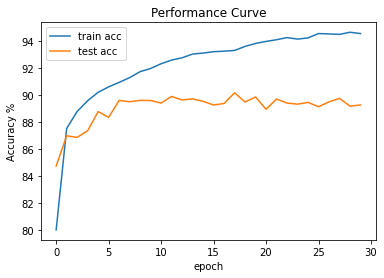

round: 3  total time used: 5.294433951377869
[1,  2000] loss:0.65797
epoch: 1 train accuary: 0.80215  test accuary: 0.8671
[2,  2000] loss:0.34572
epoch: 2 train accuary: 0.8754666666666666  test accuary: 0.8771
[3,  2000] loss:0.30461
epoch: 3 train accuary: 0.88775  test accuary: 0.8677
[4,  2000] loss:0.27414
epoch: 4 train accuary: 0.8967  test accuary: 0.8889
[5,  2000] loss:0.26072
epoch: 5 train accuary: 0.9035833333333333  test accuary: 0.8885
[6,  2000] loss:0.23934
epoch: 6 train accuary: 0.909  test accuary: 0.8854
[7,  2000] loss:0.23196
epoch: 7 train accuary: 0.91255  test accuary: 0.898
[8,  2000] loss:0.22043
epoch: 8 train accuary: 0.9159  test accuary: 0.8879
[9,  2000] loss:0.20989
epoch: 9 train accuary: 0.9176166666666666  test accuary: 0.8948
[10,  2000] loss:0.20207
epoch: 10 train accuary: 0.9214666666666667  test accuary: 0.8942
[11,  2000] loss:0.19198
epoch: 11 train accuary: 0.9251833333333334  test accuary: 0.8933
[12,  2000] loss:0.18276
epoch: 12 train ac

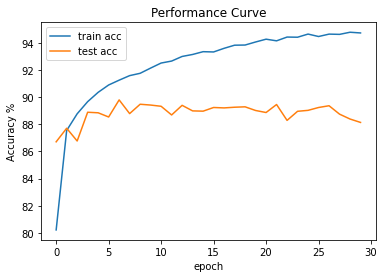

round: 4  total time used: 5.291272163391113
[1,  2000] loss:0.67318
epoch: 1 train accuary: 0.7945333333333333  test accuary: 0.8493
[2,  2000] loss:0.35455
epoch: 2 train accuary: 0.87345  test accuary: 0.8765
[3,  2000] loss:0.30490
epoch: 3 train accuary: 0.8891166666666667  test accuary: 0.8859
[4,  2000] loss:0.27586
epoch: 4 train accuary: 0.89925  test accuary: 0.8857
[5,  2000] loss:0.25576
epoch: 5 train accuary: 0.9046  test accuary: 0.8743
[6,  2000] loss:0.24284
epoch: 6 train accuary: 0.9078  test accuary: 0.8909
[7,  2000] loss:0.22726
epoch: 7 train accuary: 0.9131833333333333  test accuary: 0.8854
[8,  2000] loss:0.21372
epoch: 8 train accuary: 0.9178666666666667  test accuary: 0.8928
[9,  2000] loss:0.20784
epoch: 9 train accuary: 0.9200666666666667  test accuary: 0.8823
[10,  2000] loss:0.19547
epoch: 10 train accuary: 0.9241  test accuary: 0.8986
[11,  2000] loss:0.18825
epoch: 11 train accuary: 0.9262  test accuary: 0.8974
[12,  2000] loss:0.18241
epoch: 12 train a

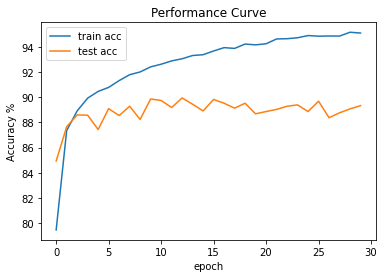

round: 5  total time used: 5.274119301637014
Best train accuracy among 5 runs: 95.34166666666667
Mean train accuracy among 5 runs: 94.98333333333332
Std train accuracy among 5 runs: 0.2892403844555592
Best test accuracy among 5 runs: 89.37
Mean test accuracy among 5 runs: 89.09599999999999
Std test accuracy among 5 runs: 0.47902400774908993


In [19]:
train_batch_size=16
test_batch_size=1000
trainloader,testloader=load_Fashion_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.005
momentum=0.9
weight_decay=1e-5
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)

Data loaded
[1,  2000] loss:0.80776
epoch: 1 train accuary: 0.7577166666666667  test accuary: 0.8242
[2,  2000] loss:0.39562
epoch: 2 train accuary: 0.8610666666666666  test accuary: 0.8678
[3,  2000] loss:0.32483
epoch: 3 train accuary: 0.8799333333333333  test accuary: 0.8815
[4,  2000] loss:0.29083
epoch: 4 train accuary: 0.8926833333333334  test accuary: 0.8838
[5,  2000] loss:0.26389
epoch: 5 train accuary: 0.8991  test accuary: 0.8815
[6,  2000] loss:0.25068
epoch: 6 train accuary: 0.9065833333333333  test accuary: 0.8891
[7,  2000] loss:0.23376
epoch: 7 train accuary: 0.9122333333333333  test accuary: 0.897
[8,  2000] loss:0.21812
epoch: 8 train accuary: 0.9171166666666667  test accuary: 0.9016
[9,  2000] loss:0.21362
epoch: 9 train accuary: 0.9203833333333333  test accuary: 0.904
[10,  2000] loss:0.20437
epoch: 10 train accuary: 0.92235  test accuary: 0.9049
[11,  2000] loss:0.19066
epoch: 11 train accuary: 0.9270666666666667  test accuary: 0.8991
[12,  2000] loss:0.18293
epoch

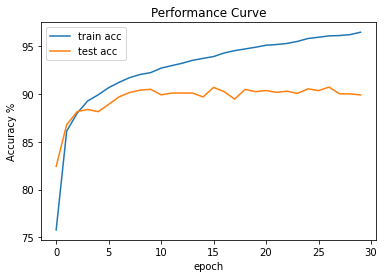

round: 1  total time used: 5.27660847902298
[1,  2000] loss:0.79333
epoch: 1 train accuary: 0.7615333333333333  test accuary: 0.8179
[2,  2000] loss:0.41073
epoch: 2 train accuary: 0.8542833333333333  test accuary: 0.8586
[3,  2000] loss:0.34401
epoch: 3 train accuary: 0.8771666666666667  test accuary: 0.8738
[4,  2000] loss:0.30504
epoch: 4 train accuary: 0.8879166666666667  test accuary: 0.888
[5,  2000] loss:0.28299
epoch: 5 train accuary: 0.8958  test accuary: 0.8909
[6,  2000] loss:0.26778
epoch: 6 train accuary: 0.9016833333333333  test accuary: 0.8861
[7,  2000] loss:0.25362
epoch: 7 train accuary: 0.9072  test accuary: 0.8915
[8,  2000] loss:0.23357
epoch: 8 train accuary: 0.9119  test accuary: 0.8966
[9,  2000] loss:0.22167
epoch: 9 train accuary: 0.9161166666666667  test accuary: 0.8989
[10,  2000] loss:0.21407
epoch: 10 train accuary: 0.91925  test accuary: 0.8958
[11,  2000] loss:0.20506
epoch: 11 train accuary: 0.9233  test accuary: 0.8942
[12,  2000] loss:0.19524
epoch: 1

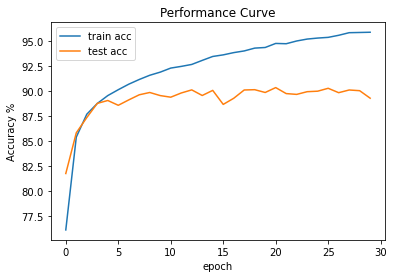

round: 2  total time used: 5.2748473683993025
[1,  2000] loss:0.80049
epoch: 1 train accuary: 0.7611666666666667  test accuary: 0.8404
[2,  2000] loss:0.38137
epoch: 2 train accuary: 0.8646  test accuary: 0.8722
[3,  2000] loss:0.31473
epoch: 3 train accuary: 0.88555  test accuary: 0.8739
[4,  2000] loss:0.28744
epoch: 4 train accuary: 0.8946833333333334  test accuary: 0.8875
[5,  2000] loss:0.26710
epoch: 5 train accuary: 0.90085  test accuary: 0.8908
[6,  2000] loss:0.25201
epoch: 6 train accuary: 0.9077333333333333  test accuary: 0.8969
[7,  2000] loss:0.23021
epoch: 7 train accuary: 0.9117833333333333  test accuary: 0.8969
[8,  2000] loss:0.21639
epoch: 8 train accuary: 0.9165666666666666  test accuary: 0.8984
[9,  2000] loss:0.20830
epoch: 9 train accuary: 0.9215  test accuary: 0.8997
[10,  2000] loss:0.20071
epoch: 10 train accuary: 0.9237333333333333  test accuary: 0.9053
[11,  2000] loss:0.18947
epoch: 11 train accuary: 0.9288833333333333  test accuary: 0.9003
[12,  2000] loss:

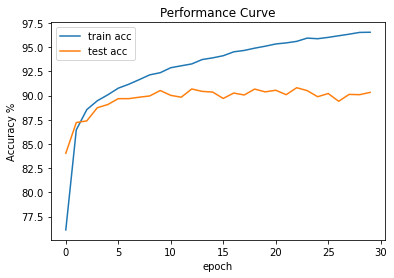

round: 3  total time used: 5.2724500815073645
[1,  2000] loss:0.79454
epoch: 1 train accuary: 0.7661  test accuary: 0.8474
[2,  2000] loss:0.37143
epoch: 2 train accuary: 0.8680166666666667  test accuary: 0.875
[3,  2000] loss:0.31803
epoch: 3 train accuary: 0.88545  test accuary: 0.878
[4,  2000] loss:0.28489
epoch: 4 train accuary: 0.8954333333333333  test accuary: 0.8888
[5,  2000] loss:0.26879
epoch: 5 train accuary: 0.9007166666666667  test accuary: 0.8922
[6,  2000] loss:0.24809
epoch: 6 train accuary: 0.9074333333333333  test accuary: 0.8937
[7,  2000] loss:0.23447
epoch: 7 train accuary: 0.91125  test accuary: 0.8922
[8,  2000] loss:0.22639
epoch: 8 train accuary: 0.9148  test accuary: 0.8993
[9,  2000] loss:0.21196
epoch: 9 train accuary: 0.9192333333333333  test accuary: 0.8978
[10,  2000] loss:0.20643
epoch: 10 train accuary: 0.9216  test accuary: 0.9039
[11,  2000] loss:0.19433
epoch: 11 train accuary: 0.92525  test accuary: 0.9033
[12,  2000] loss:0.18533
epoch: 12 train a

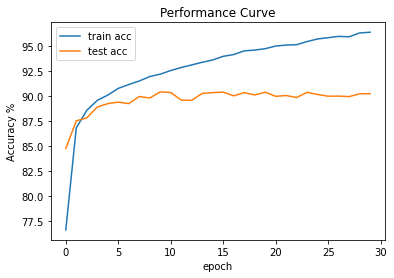

round: 4  total time used: 5.270602246125539
[1,  2000] loss:0.77617
epoch: 1 train accuary: 0.7656  test accuary: 0.8553
[2,  2000] loss:0.38066
epoch: 2 train accuary: 0.8671666666666666  test accuary: 0.8694
[3,  2000] loss:0.32381
epoch: 3 train accuary: 0.8829166666666667  test accuary: 0.8738
[4,  2000] loss:0.29035
epoch: 4 train accuary: 0.8934  test accuary: 0.8821
[5,  2000] loss:0.26961
epoch: 5 train accuary: 0.9007166666666667  test accuary: 0.8919
[6,  2000] loss:0.24774
epoch: 6 train accuary: 0.9071166666666667  test accuary: 0.8912
[7,  2000] loss:0.23284
epoch: 7 train accuary: 0.91155  test accuary: 0.8914
[8,  2000] loss:0.22178
epoch: 8 train accuary: 0.9178  test accuary: 0.9013
[9,  2000] loss:0.21171
epoch: 9 train accuary: 0.9198166666666666  test accuary: 0.9013
[10,  2000] loss:0.19963
epoch: 10 train accuary: 0.9239333333333334  test accuary: 0.8994
[11,  2000] loss:0.18724
epoch: 11 train accuary: 0.9275333333333333  test accuary: 0.9036
[12,  2000] loss:0.

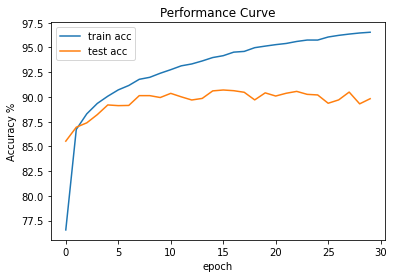

round: 5  total time used: 5.281924239794413
Best train accuracy among 5 runs: 96.55666666666667
Mean train accuracy among 5 runs: 96.36266666666667
Std train accuracy among 5 runs: 0.237221415559393
Best test accuracy among 5 runs: 90.34
Mean test accuracy among 5 runs: 89.91799999999999
Std test accuracy among 5 runs: 0.3552126123886979


In [20]:
train_batch_size=16
test_batch_size=1000
trainloader,testloader=load_Fashion_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.01
momentum=0.5
weight_decay=1e-6
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)

Data loaded
[1,  2000] loss:1.34245
[1,  4000] loss:0.64642
[1,  6000] loss:0.54118
epoch: 1 train accuary: 0.6937833333333333  test accuary: 0.8026
[2,  2000] loss:0.47433
[2,  4000] loss:0.44274
[2,  6000] loss:0.41554
epoch: 2 train accuary: 0.8389333333333333  test accuary: 0.8498
[3,  2000] loss:0.38868
[3,  4000] loss:0.36724
[3,  6000] loss:0.36865
epoch: 3 train accuary: 0.8628666666666667  test accuary: 0.8567
[4,  2000] loss:0.34309
[4,  4000] loss:0.34401
[4,  6000] loss:0.32278
epoch: 4 train accuary: 0.8766833333333334  test accuary: 0.8679
[5,  2000] loss:0.31721
[5,  4000] loss:0.31543
[5,  6000] loss:0.30024
epoch: 5 train accuary: 0.88445  test accuary: 0.8841
[6,  2000] loss:0.29640
[6,  4000] loss:0.28937
[6,  6000] loss:0.28844
epoch: 6 train accuary: 0.8929666666666667  test accuary: 0.8856
[7,  2000] loss:0.27777
[7,  4000] loss:0.28026
[7,  6000] loss:0.27606
epoch: 7 train accuary: 0.8981166666666667  test accuary: 0.8879
[8,  2000] loss:0.27079
[8,  4000] loss:

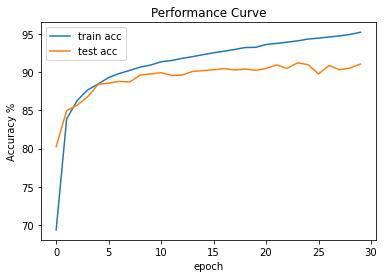

round: 1  total time used: 7.344428690274556
[1,  2000] loss:1.31664
[1,  4000] loss:0.70517
[1,  6000] loss:0.59773
epoch: 1 train accuary: 0.6817  test accuary: 0.7886
[2,  2000] loss:0.51896
[2,  4000] loss:0.48274
[2,  6000] loss:0.44190
epoch: 2 train accuary: 0.8239  test accuary: 0.8398
[3,  2000] loss:0.41529
[3,  4000] loss:0.39711
[3,  6000] loss:0.37873
epoch: 3 train accuary: 0.855  test accuary: 0.8492
[4,  2000] loss:0.35743
[4,  4000] loss:0.35474
[4,  6000] loss:0.35223
epoch: 4 train accuary: 0.8704166666666666  test accuary: 0.8601
[5,  2000] loss:0.32453
[5,  4000] loss:0.32588
[5,  6000] loss:0.32868
epoch: 5 train accuary: 0.8799166666666667  test accuary: 0.879
[6,  2000] loss:0.31368
[6,  4000] loss:0.30549
[6,  6000] loss:0.29722
epoch: 6 train accuary: 0.8881833333333333  test accuary: 0.8818
[7,  2000] loss:0.29395
[7,  4000] loss:0.28695
[7,  6000] loss:0.29089
epoch: 7 train accuary: 0.8919833333333334  test accuary: 0.8807
[8,  2000] loss:0.27709
[8,  4000]

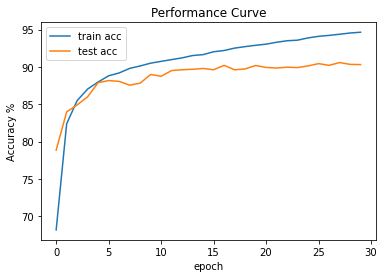

round: 2  total time used: 8.213687849044799
[1,  2000] loss:1.22138
[1,  4000] loss:0.68254
[1,  6000] loss:0.56731
epoch: 1 train accuary: 0.6934  test accuary: 0.8026
[2,  2000] loss:0.50961
[2,  4000] loss:0.45975
[2,  6000] loss:0.44513
epoch: 2 train accuary: 0.8286833333333333  test accuary: 0.8453
[3,  2000] loss:0.40644
[3,  4000] loss:0.39792
[3,  6000] loss:0.38196
epoch: 3 train accuary: 0.8562833333333333  test accuary: 0.8579
[4,  2000] loss:0.36023
[4,  4000] loss:0.34682
[4,  6000] loss:0.35220
epoch: 4 train accuary: 0.87115  test accuary: 0.8628
[5,  2000] loss:0.32886
[5,  4000] loss:0.32155
[5,  6000] loss:0.32037
epoch: 5 train accuary: 0.8809333333333333  test accuary: 0.8728
[6,  2000] loss:0.30771
[6,  4000] loss:0.29970
[6,  6000] loss:0.30466
epoch: 6 train accuary: 0.8879  test accuary: 0.8784
[7,  2000] loss:0.29030
[7,  4000] loss:0.28588
[7,  6000] loss:0.28717
epoch: 7 train accuary: 0.8938333333333334  test accuary: 0.8821
[8,  2000] loss:0.27667
[8,  40

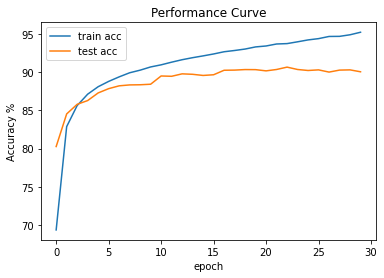

round: 3  total time used: 8.506953235467275
[1,  2000] loss:1.15493
[1,  4000] loss:0.66884
[1,  6000] loss:0.56278
epoch: 1 train accuary: 0.70485  test accuary: 0.8072
[2,  2000] loss:0.50732
[2,  4000] loss:0.45616
[2,  6000] loss:0.42272
epoch: 2 train accuary: 0.8302833333333334  test accuary: 0.8415
[3,  2000] loss:0.40681
[3,  4000] loss:0.38762
[3,  6000] loss:0.36435
epoch: 3 train accuary: 0.8588333333333333  test accuary: 0.851
[4,  2000] loss:0.34521
[4,  4000] loss:0.34297
[4,  6000] loss:0.34325
epoch: 4 train accuary: 0.8751666666666666  test accuary: 0.8649
[5,  2000] loss:0.32408
[5,  4000] loss:0.31591
[5,  6000] loss:0.30921
epoch: 5 train accuary: 0.8840666666666667  test accuary: 0.8606
[6,  2000] loss:0.30034
[6,  4000] loss:0.29220
[6,  6000] loss:0.29181
epoch: 6 train accuary: 0.8919666666666667  test accuary: 0.8805
[7,  2000] loss:0.28145
[7,  4000] loss:0.27883
[7,  6000] loss:0.27395
epoch: 7 train accuary: 0.8984333333333333  test accuary: 0.8837
[8,  200

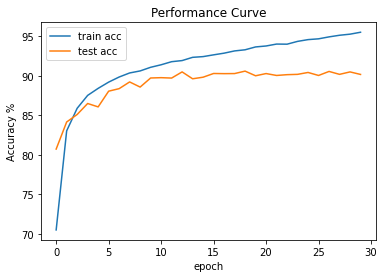

round: 4  total time used: 8.843673555056254
[1,  2000] loss:1.18338
[1,  4000] loss:0.66942
[1,  6000] loss:0.56136
epoch: 1 train accuary: 0.7049333333333333  test accuary: 0.807
[2,  2000] loss:0.50051
[2,  4000] loss:0.44870
[2,  6000] loss:0.41134
epoch: 2 train accuary: 0.8352666666666667  test accuary: 0.8443
[3,  2000] loss:0.40074
[3,  4000] loss:0.37398
[3,  6000] loss:0.35902
epoch: 3 train accuary: 0.8616666666666667  test accuary: 0.8703
[4,  2000] loss:0.35271
[4,  4000] loss:0.33888
[4,  6000] loss:0.32762
epoch: 4 train accuary: 0.8761833333333333  test accuary: 0.8788
[5,  2000] loss:0.32219
[5,  4000] loss:0.31028
[5,  6000] loss:0.31109
epoch: 5 train accuary: 0.8850833333333333  test accuary: 0.8841
[6,  2000] loss:0.30180
[6,  4000] loss:0.30366
[6,  6000] loss:0.28301
epoch: 6 train accuary: 0.8912666666666667  test accuary: 0.8896
[7,  2000] loss:0.28237
[7,  4000] loss:0.28336
[7,  6000] loss:0.27212
epoch: 7 train accuary: 0.8972166666666667  test accuary: 0.89

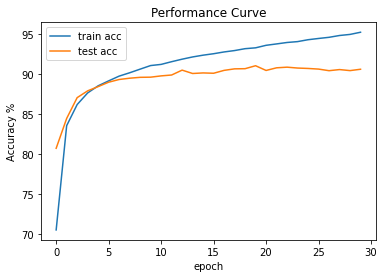

round: 5  total time used: 8.929038838545482
Best train accuracy among 5 runs: 95.51166666666666
Mean train accuracy among 5 runs: 95.16266666666667
Std train accuracy among 5 runs: 0.2792979293394985
Best test accuracy among 5 runs: 91.06
Mean test accuracy among 5 runs: 90.436
Std test accuracy among 5 runs: 0.3586976442632465


In [21]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_Fashion_data(train_batch_size,test_batch_size)
channel=1
size=28
epoch=30
learning_rate=0.0005
momentum=0.9
weight_decay=1e-6
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)

In [22]:
##CIFAR Data

Files already downloaded and verified
Files already downloaded and verified
Data loaded
[1,  2000] loss:2.05066
[1,  4000] loss:1.63071
epoch: 1 train accuary: 0.34604  test accuary: 0.4485
[2,  2000] loss:1.44993
[2,  4000] loss:1.38278
epoch: 2 train accuary: 0.49056  test accuary: 0.5164
[3,  2000] loss:1.27053
[3,  4000] loss:1.24572
epoch: 3 train accuary: 0.55454  test accuary: 0.5365
[4,  2000] loss:1.16410
[4,  4000] loss:1.14266
epoch: 4 train accuary: 0.59362  test accuary: 0.5846
[5,  2000] loss:1.07502
[5,  4000] loss:1.07716
epoch: 5 train accuary: 0.62132  test accuary: 0.6022
[6,  2000] loss:1.01195
[6,  4000] loss:1.01069
epoch: 6 train accuary: 0.6428  test accuary: 0.6165
[7,  2000] loss:0.94825
[7,  4000] loss:0.96728
epoch: 7 train accuary: 0.66398  test accuary: 0.6365
[8,  2000] loss:0.89920
[8,  4000] loss:0.91460
epoch: 8 train accuary: 0.67992  test accuary: 0.6354
[9,  2000] loss:0.85440
[9,  4000] loss:0.87004
epoch: 9 train accuary: 0.69364  test accuary: 0.

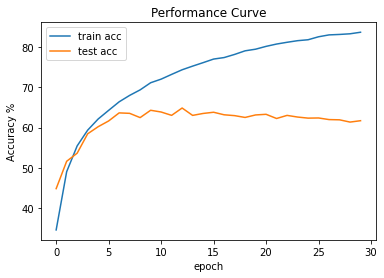

round: 1  total time used: 8.875991137822469
[1,  2000] loss:2.07216
[1,  4000] loss:1.66302
epoch: 1 train accuary: 0.33976  test accuary: 0.4505
[2,  2000] loss:1.45372
[2,  4000] loss:1.38565
epoch: 2 train accuary: 0.48942  test accuary: 0.5078
[3,  2000] loss:1.28352
[3,  4000] loss:1.25257
epoch: 3 train accuary: 0.55126  test accuary: 0.542
[4,  2000] loss:1.16305
[4,  4000] loss:1.14433
epoch: 4 train accuary: 0.5901  test accuary: 0.5928
[5,  2000] loss:1.06973
[5,  4000] loss:1.08388
epoch: 5 train accuary: 0.61842  test accuary: 0.6102
[6,  2000] loss:1.01739
[6,  4000] loss:1.02099
epoch: 6 train accuary: 0.63886  test accuary: 0.6103
[7,  2000] loss:0.96089
[7,  4000] loss:0.97844
epoch: 7 train accuary: 0.65918  test accuary: 0.6205
[8,  2000] loss:0.90513
[8,  4000] loss:0.93594
epoch: 8 train accuary: 0.67328  test accuary: 0.6296
[9,  2000] loss:0.87413
[9,  4000] loss:0.87529
epoch: 9 train accuary: 0.68934  test accuary: 0.6293
[10,  2000] loss:0.82590
[10,  4000] lo

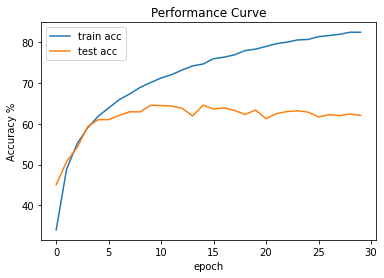

round: 2  total time used: 8.286484082539877
[1,  2000] loss:2.02981
[1,  4000] loss:1.60132
epoch: 1 train accuary: 0.35374  test accuary: 0.4722
[2,  2000] loss:1.42367
[2,  4000] loss:1.36501
epoch: 2 train accuary: 0.50438  test accuary: 0.5497
[3,  2000] loss:1.24940
[3,  4000] loss:1.23326
epoch: 3 train accuary: 0.56188  test accuary: 0.5608
[4,  2000] loss:1.14764
[4,  4000] loss:1.12872
epoch: 4 train accuary: 0.59642  test accuary: 0.5838
[5,  2000] loss:1.06580
[5,  4000] loss:1.06464
epoch: 5 train accuary: 0.6232  test accuary: 0.6055
[6,  2000] loss:0.98886
[6,  4000] loss:1.01002
epoch: 6 train accuary: 0.64754  test accuary: 0.6164
[7,  2000] loss:0.93323
[7,  4000] loss:0.95646
epoch: 7 train accuary: 0.66762  test accuary: 0.6074
[8,  2000] loss:0.88714
[8,  4000] loss:0.91370
epoch: 8 train accuary: 0.68298  test accuary: 0.6244
[9,  2000] loss:0.84720
[9,  4000] loss:0.86527
epoch: 9 train accuary: 0.6963  test accuary: 0.6227
[10,  2000] loss:0.79925
[10,  4000] lo

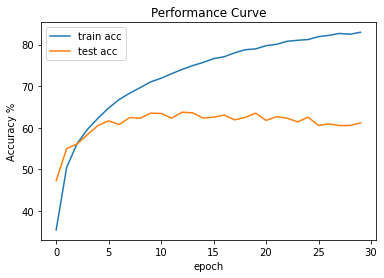

round: 3  total time used: 8.514089035987855
[1,  2000] loss:2.05616
[1,  4000] loss:1.63654
epoch: 1 train accuary: 0.34398  test accuary: 0.4631
[2,  2000] loss:1.43581
[2,  4000] loss:1.34923
epoch: 2 train accuary: 0.50294  test accuary: 0.5409
[3,  2000] loss:1.24228
[3,  4000] loss:1.23152
epoch: 3 train accuary: 0.56234  test accuary: 0.5767
[4,  2000] loss:1.11679
[4,  4000] loss:1.13293
epoch: 4 train accuary: 0.60294  test accuary: 0.6066
[5,  2000] loss:1.05578
[5,  4000] loss:1.03951
epoch: 5 train accuary: 0.62912  test accuary: 0.6138
[6,  2000] loss:0.99299
[6,  4000] loss:0.98484
epoch: 6 train accuary: 0.65068  test accuary: 0.627
[7,  2000] loss:0.93530
[7,  4000] loss:0.93697
epoch: 7 train accuary: 0.67082  test accuary: 0.6229
[8,  2000] loss:0.86936
[8,  4000] loss:0.90708
epoch: 8 train accuary: 0.68572  test accuary: 0.6299
[9,  2000] loss:0.83535
[9,  4000] loss:0.85324
epoch: 9 train accuary: 0.70218  test accuary: 0.6239
[10,  2000] loss:0.78484
[10,  4000] l

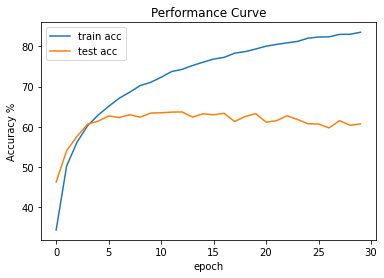

round: 4  total time used: 8.75992845694224
[1,  2000] loss:2.01907
[1,  4000] loss:1.62172
epoch: 1 train accuary: 0.35544  test accuary: 0.4686
[2,  2000] loss:1.41823
[2,  4000] loss:1.35416
epoch: 2 train accuary: 0.50774  test accuary: 0.5519
[3,  2000] loss:1.25137
[3,  4000] loss:1.22854
epoch: 3 train accuary: 0.5629  test accuary: 0.5664
[4,  2000] loss:1.13895
[4,  4000] loss:1.14670
epoch: 4 train accuary: 0.59812  test accuary: 0.5734
[5,  2000] loss:1.07042
[5,  4000] loss:1.06804
epoch: 5 train accuary: 0.62532  test accuary: 0.6076
[6,  2000] loss:0.99732
[6,  4000] loss:1.02115
epoch: 6 train accuary: 0.64558  test accuary: 0.625
[7,  2000] loss:0.94688
[7,  4000] loss:0.96929
epoch: 7 train accuary: 0.66322  test accuary: 0.6251
[8,  2000] loss:0.89577
[8,  4000] loss:0.91510
epoch: 8 train accuary: 0.68156  test accuary: 0.6348
[9,  2000] loss:0.86201
[9,  4000] loss:0.86733
epoch: 9 train accuary: 0.69328  test accuary: 0.6337
[10,  2000] loss:0.81372
[10,  4000] los

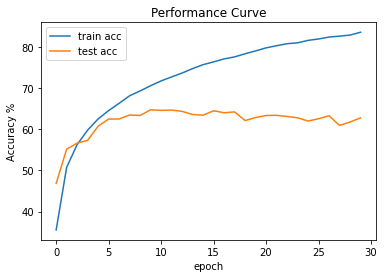

round: 5  total time used: 8.71043014129003
Best train accuracy among 5 runs: 83.66799999999999
Mean train accuracy among 5 runs: 83.23519999999999
Std train accuracy among 5 runs: 0.45601859611204304
Best test accuracy among 5 runs: 62.78
Mean test accuracy among 5 runs: 61.681999999999995
Std test accuracy among 5 runs: 0.7130049088190071


In [23]:
#notgood
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_CIFAR_data(train_batch_size,test_batch_size)
channel=3
size=32
epoch=30
learning_rate=0.001
momentum=0.9
weight_decay=1e-5
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Files already downloaded and verified
Files already downloaded and verified
Data loaded
[1,  2000] loss:2.06761
[1,  4000] loss:1.64869
epoch: 1 train accuary: 0.3427  test accuary: 0.4348
[2,  2000] loss:1.45789
[2,  4000] loss:1.37278
epoch: 2 train accuary: 0.4959  test accuary: 0.5271
[3,  2000] loss:1.27664
[3,  4000] loss:1.25103
epoch: 3 train accuary: 0.5508  test accuary: 0.5612
[4,  2000] loss:1.16345
[4,  4000] loss:1.16373
epoch: 4 train accuary: 0.58898  test accuary: 0.581
[5,  2000] loss:1.09122
[5,  4000] loss:1.09758
epoch: 5 train accuary: 0.61386  test accuary: 0.5952
[6,  2000] loss:1.03237
[6,  4000] loss:1.04726
epoch: 6 train accuary: 0.63136  test accuary: 0.6113
[7,  2000] loss:0.98225
[7,  4000] loss:0.99545
epoch: 7 train accuary: 0.65026  test accuary: 0.6091
[8,  2000] loss:0.94357
[8,  4000] loss:0.95881
epoch: 8 train accuary: 0.66496  test accuary: 0.6327
[9,  2000] loss:0.89706
[9,  4000] loss:0.92533
epoch: 9 train accuary: 0.6768  test accuary: 0.6276

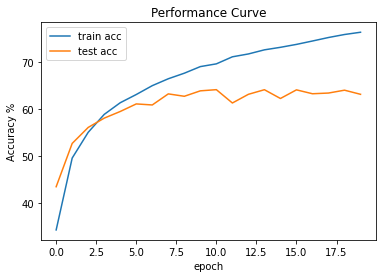

round: 1  total time used: 5.197899353504181
[1,  2000] loss:2.03659
[1,  4000] loss:1.61864
epoch: 1 train accuary: 0.3531  test accuary: 0.4561
[2,  2000] loss:1.43225
[2,  4000] loss:1.37768
epoch: 2 train accuary: 0.49902  test accuary: 0.5366
[3,  2000] loss:1.25468
[3,  4000] loss:1.23125
epoch: 3 train accuary: 0.56124  test accuary: 0.5841
[4,  2000] loss:1.14688
[4,  4000] loss:1.13676
epoch: 4 train accuary: 0.5971  test accuary: 0.604
[5,  2000] loss:1.05776
[5,  4000] loss:1.06556
epoch: 5 train accuary: 0.62768  test accuary: 0.6253
[6,  2000] loss:0.99225
[6,  4000] loss:0.98622
epoch: 6 train accuary: 0.65078  test accuary: 0.6185
[7,  2000] loss:0.93844
[7,  4000] loss:0.95487
epoch: 7 train accuary: 0.67142  test accuary: 0.6475
[8,  2000] loss:0.88228
[8,  4000] loss:0.90352
epoch: 8 train accuary: 0.68582  test accuary: 0.641
[9,  2000] loss:0.84550
[9,  4000] loss:0.86609
epoch: 9 train accuary: 0.70004  test accuary: 0.6371
[10,  2000] loss:0.80104
[10,  4000] loss

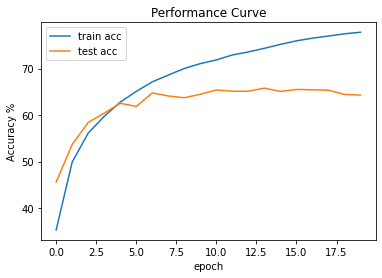

round: 2  total time used: 5.246401460965474
[1,  2000] loss:2.04843
[1,  4000] loss:1.61534
epoch: 1 train accuary: 0.3504  test accuary: 0.4726
[2,  2000] loss:1.42805
[2,  4000] loss:1.37704
epoch: 2 train accuary: 0.49802  test accuary: 0.5113
[3,  2000] loss:1.26604
[3,  4000] loss:1.23092
epoch: 3 train accuary: 0.5556  test accuary: 0.5722
[4,  2000] loss:1.14955
[4,  4000] loss:1.14528
epoch: 4 train accuary: 0.59424  test accuary: 0.599
[5,  2000] loss:1.07789
[5,  4000] loss:1.06237
epoch: 5 train accuary: 0.6239  test accuary: 0.6054
[6,  2000] loss:1.00377
[6,  4000] loss:1.02299
epoch: 6 train accuary: 0.64644  test accuary: 0.6224
[7,  2000] loss:0.96053
[7,  4000] loss:0.94436
epoch: 7 train accuary: 0.66462  test accuary: 0.6349
[8,  2000] loss:0.90626
[8,  4000] loss:0.92220
epoch: 8 train accuary: 0.68066  test accuary: 0.6429
[9,  2000] loss:0.86361
[9,  4000] loss:0.89004
epoch: 9 train accuary: 0.6915  test accuary: 0.6541
[10,  2000] loss:0.82970
[10,  4000] loss:

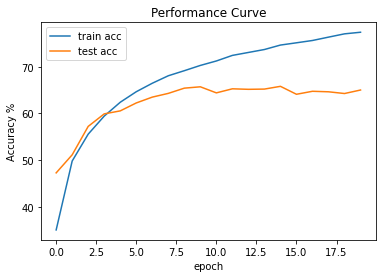

round: 3  total time used: 5.2004923264185585
[1,  2000] loss:2.07087
[1,  4000] loss:1.66327
epoch: 1 train accuary: 0.33818  test accuary: 0.4328
[2,  2000] loss:1.45952
[2,  4000] loss:1.38995
epoch: 2 train accuary: 0.49136  test accuary: 0.5233
[3,  2000] loss:1.28149
[3,  4000] loss:1.22576
epoch: 3 train accuary: 0.55346  test accuary: 0.5794
[4,  2000] loss:1.15637
[4,  4000] loss:1.14811
epoch: 4 train accuary: 0.59242  test accuary: 0.6071
[5,  2000] loss:1.06683
[5,  4000] loss:1.06636
epoch: 5 train accuary: 0.62276  test accuary: 0.6063
[6,  2000] loss:1.01308
[6,  4000] loss:0.98975
epoch: 6 train accuary: 0.64678  test accuary: 0.6214
[7,  2000] loss:0.94495
[7,  4000] loss:0.95511
epoch: 7 train accuary: 0.66654  test accuary: 0.6262
[8,  2000] loss:0.90109
[8,  4000] loss:0.91254
epoch: 8 train accuary: 0.68014  test accuary: 0.6381
[9,  2000] loss:0.85662
[9,  4000] loss:0.88402
epoch: 9 train accuary: 0.69316  test accuary: 0.6521
[10,  2000] loss:0.81849
[10,  4000]

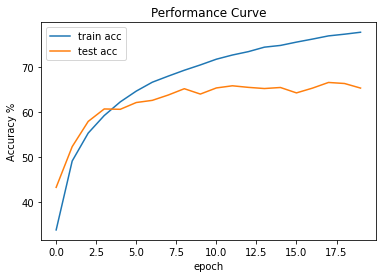

round: 4  total time used: 5.256878884633382
[1,  2000] loss:2.04605
[1,  4000] loss:1.63662
epoch: 1 train accuary: 0.3453  test accuary: 0.4726
[2,  2000] loss:1.44185
[2,  4000] loss:1.38044
epoch: 2 train accuary: 0.49692  test accuary: 0.532
[3,  2000] loss:1.27294
[3,  4000] loss:1.24053
epoch: 3 train accuary: 0.55356  test accuary: 0.5566
[4,  2000] loss:1.17059
[4,  4000] loss:1.14857
epoch: 4 train accuary: 0.58684  test accuary: 0.5867
[5,  2000] loss:1.08437
[5,  4000] loss:1.09005
epoch: 5 train accuary: 0.61854  test accuary: 0.5952
[6,  2000] loss:1.01442
[6,  4000] loss:1.02435
epoch: 6 train accuary: 0.64012  test accuary: 0.6198
[7,  2000] loss:0.96289
[7,  4000] loss:0.97599
epoch: 7 train accuary: 0.65868  test accuary: 0.6264
[8,  2000] loss:0.91331
[8,  4000] loss:0.93388
epoch: 8 train accuary: 0.67446  test accuary: 0.6479
[9,  2000] loss:0.86964
[9,  4000] loss:0.89482
epoch: 9 train accuary: 0.68822  test accuary: 0.6441
[10,  2000] loss:0.83044
[10,  4000] lo

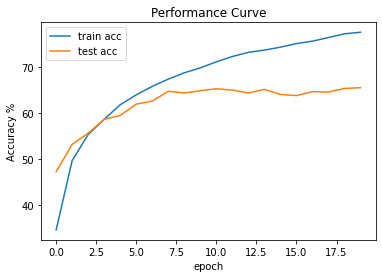

round: 5  total time used: 5.122780319054922
Best train accuracy among 5 runs: 77.794
Mean train accuracy among 5 runs: 77.4068
Std train accuracy among 5 runs: 0.5176803647039326
Best test accuracy among 5 runs: 65.57
Mean test accuracy among 5 runs: 64.68
Std test accuracy among 5 runs: 0.8662563131083062


In [32]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_CIFAR_data(train_batch_size,test_batch_size)
channel=3
size=32
epoch=20
learning_rate=0.001
momentum=0.9
weight_decay=1e-3
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Files already downloaded and verified
Files already downloaded and verified
Data loaded
[1,  2000] loss:2.29637
epoch: 1 train accuary: 0.13636  test accuary: 0.1531
[2,  2000] loss:2.08875
epoch: 2 train accuary: 0.25662  test accuary: 0.3067
[3,  2000] loss:1.86116
epoch: 3 train accuary: 0.33808  test accuary: 0.3735
[4,  2000] loss:1.68735
epoch: 4 train accuary: 0.39528  test accuary: 0.4201
[5,  2000] loss:1.59030
epoch: 5 train accuary: 0.42598  test accuary: 0.4441
[6,  2000] loss:1.53535
epoch: 6 train accuary: 0.45048  test accuary: 0.4545
[7,  2000] loss:1.48005
epoch: 7 train accuary: 0.46368  test accuary: 0.4684
[8,  2000] loss:1.44975
epoch: 8 train accuary: 0.4781  test accuary: 0.4827
[9,  2000] loss:1.41728
epoch: 9 train accuary: 0.49116  test accuary: 0.4882
[10,  2000] loss:1.39228
epoch: 10 train accuary: 0.49876  test accuary: 0.4959
[11,  2000] loss:1.36669
epoch: 11 train accuary: 0.50988  test accuary: 0.5179
[12,  2000] loss:1.33971
epoch: 12 train accuary: 0

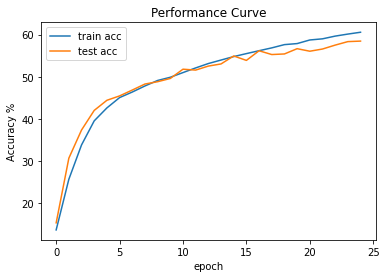

round: 1  total time used: 4.961524669329325
[1,  2000] loss:2.29685
epoch: 1 train accuary: 0.13538  test accuary: 0.1827
[2,  2000] loss:2.10965
epoch: 2 train accuary: 0.2532  test accuary: 0.3106
[3,  2000] loss:1.85291
epoch: 3 train accuary: 0.33836  test accuary: 0.3716
[4,  2000] loss:1.69306
epoch: 4 train accuary: 0.38666  test accuary: 0.407
[5,  2000] loss:1.58766
epoch: 5 train accuary: 0.42154  test accuary: 0.4278
[6,  2000] loss:1.52475
epoch: 6 train accuary: 0.4485  test accuary: 0.4651
[7,  2000] loss:1.47073
epoch: 7 train accuary: 0.47014  test accuary: 0.4748
[8,  2000] loss:1.43473
epoch: 8 train accuary: 0.48326  test accuary: 0.4929
[9,  2000] loss:1.39569
epoch: 9 train accuary: 0.49764  test accuary: 0.5042
[10,  2000] loss:1.37335
epoch: 10 train accuary: 0.50992  test accuary: 0.5144
[11,  2000] loss:1.34422
epoch: 11 train accuary: 0.5207  test accuary: 0.5135
[12,  2000] loss:1.31429
epoch: 12 train accuary: 0.53162  test accuary: 0.5259
[13,  2000] loss:

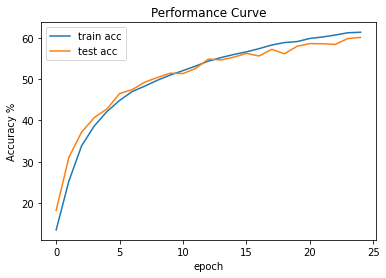

round: 2  total time used: 4.959079154332479
[1,  2000] loss:2.29828
epoch: 1 train accuary: 0.1284  test accuary: 0.1535
[2,  2000] loss:2.21091
epoch: 2 train accuary: 0.20908  test accuary: 0.2707
[3,  2000] loss:1.97121
epoch: 3 train accuary: 0.29498  test accuary: 0.3362
[4,  2000] loss:1.79399
epoch: 4 train accuary: 0.3589  test accuary: 0.3856
[5,  2000] loss:1.65914
epoch: 5 train accuary: 0.4046  test accuary: 0.4229
[6,  2000] loss:1.58525
epoch: 6 train accuary: 0.43218  test accuary: 0.4351
[7,  2000] loss:1.53414
epoch: 7 train accuary: 0.45024  test accuary: 0.4556
[8,  2000] loss:1.49153
epoch: 8 train accuary: 0.46628  test accuary: 0.471
[9,  2000] loss:1.45798
epoch: 9 train accuary: 0.47806  test accuary: 0.4855
[10,  2000] loss:1.43526
epoch: 10 train accuary: 0.48842  test accuary: 0.4959
[11,  2000] loss:1.40756
epoch: 11 train accuary: 0.49552  test accuary: 0.4978
[12,  2000] loss:1.38064
epoch: 12 train accuary: 0.50674  test accuary: 0.5025
[13,  2000] loss:

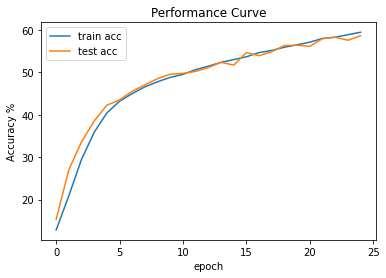

round: 3  total time used: 4.97786846558253
[1,  2000] loss:2.29878
epoch: 1 train accuary: 0.12004  test accuary: 0.1876
[2,  2000] loss:2.07722
epoch: 2 train accuary: 0.26066  test accuary: 0.3067
[3,  2000] loss:1.86944
epoch: 3 train accuary: 0.33168  test accuary: 0.3727
[4,  2000] loss:1.69299
epoch: 4 train accuary: 0.3892  test accuary: 0.41
[5,  2000] loss:1.59408
epoch: 5 train accuary: 0.42564  test accuary: 0.4481
[6,  2000] loss:1.52146
epoch: 6 train accuary: 0.45148  test accuary: 0.4576
[7,  2000] loss:1.46842
epoch: 7 train accuary: 0.469  test accuary: 0.482
[8,  2000] loss:1.42750
epoch: 8 train accuary: 0.48686  test accuary: 0.4853
[9,  2000] loss:1.40107
epoch: 9 train accuary: 0.50172  test accuary: 0.5022
[10,  2000] loss:1.35798
epoch: 10 train accuary: 0.51312  test accuary: 0.511
[11,  2000] loss:1.33758
epoch: 11 train accuary: 0.52392  test accuary: 0.5167
[12,  2000] loss:1.31158
epoch: 12 train accuary: 0.53304  test accuary: 0.5356
[13,  2000] loss:1.28

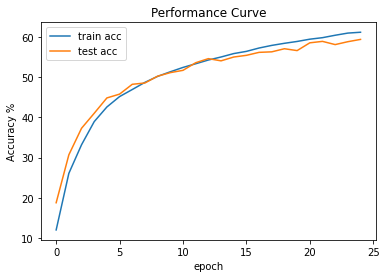

round: 4  total time used: 4.95412437915802
[1,  2000] loss:2.28136
epoch: 1 train accuary: 0.15794  test accuary: 0.2512
[2,  2000] loss:2.01252
epoch: 2 train accuary: 0.28986  test accuary: 0.3373
[3,  2000] loss:1.79056
epoch: 3 train accuary: 0.36346  test accuary: 0.382
[4,  2000] loss:1.64147
epoch: 4 train accuary: 0.40896  test accuary: 0.4323
[5,  2000] loss:1.55139
epoch: 5 train accuary: 0.44164  test accuary: 0.4607
[6,  2000] loss:1.48424
epoch: 6 train accuary: 0.46276  test accuary: 0.478
[7,  2000] loss:1.43860
epoch: 7 train accuary: 0.48388  test accuary: 0.4866
[8,  2000] loss:1.40035
epoch: 8 train accuary: 0.49698  test accuary: 0.5017
[9,  2000] loss:1.36157
epoch: 9 train accuary: 0.51148  test accuary: 0.5164
[10,  2000] loss:1.33201
epoch: 10 train accuary: 0.52382  test accuary: 0.5305
[11,  2000] loss:1.30783
epoch: 11 train accuary: 0.53794  test accuary: 0.5307
[12,  2000] loss:1.26790
epoch: 12 train accuary: 0.54584  test accuary: 0.55
[13,  2000] loss:1

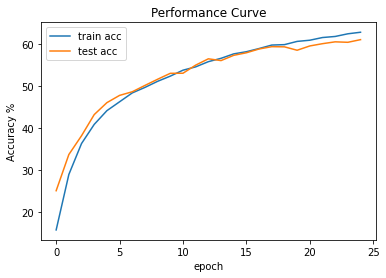

round: 5  total time used: 4.939282496770223
Best train accuracy among 5 runs: 62.822
Mean train accuracy among 5 runs: 61.0732
Std train accuracy among 5 runs: 1.0847064856448505
Best test accuracy among 5 runs: 61.06
Mean test accuracy among 5 runs: 59.53000000000001
Std test accuracy among 5 runs: 0.9569952977940901


In [25]:
train_batch_size=16
test_batch_size=1000
trainloader,testloader=load_CIFAR_data(train_batch_size,test_batch_size)
channel=3
size=32
epoch=25
learning_rate=0.001
momentum=0.5
weight_decay=1e-2
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Files already downloaded and verified
Files already downloaded and verified
Data loaded
[1,  2000] loss:2.28137
[1,  4000] loss:2.16067
epoch: 1 train accuary: 0.17258  test accuary: 0.283
[2,  2000] loss:1.94473
[2,  4000] loss:1.79053
epoch: 2 train accuary: 0.32982  test accuary: 0.3868
[3,  2000] loss:1.65326
[3,  4000] loss:1.60632
epoch: 3 train accuary: 0.40434  test accuary: 0.4341
[4,  2000] loss:1.54673
[4,  4000] loss:1.52054
epoch: 4 train accuary: 0.44366  test accuary: 0.4408
[5,  2000] loss:1.48351
[5,  4000] loss:1.46218
epoch: 5 train accuary: 0.4687  test accuary: 0.4856
[6,  2000] loss:1.43377
[6,  4000] loss:1.41297
epoch: 6 train accuary: 0.48878  test accuary: 0.4888
[7,  2000] loss:1.37659
[7,  4000] loss:1.37839
epoch: 7 train accuary: 0.5049  test accuary: 0.5162
[8,  2000] loss:1.34787
[8,  4000] loss:1.32270
epoch: 8 train accuary: 0.522  test accuary: 0.5308
[9,  2000] loss:1.30937
[9,  4000] loss:1.28566
epoch: 9 train accuary: 0.5387  test accuary: 0.5365


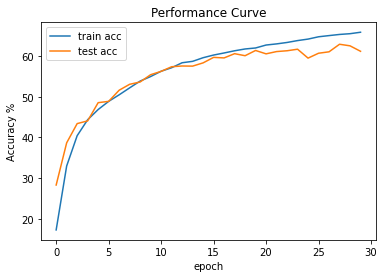

round: 1  total time used: 7.589798927307129
[1,  2000] loss:2.28025
[1,  4000] loss:2.14434
epoch: 1 train accuary: 0.21548  test accuary: 0.2875
[2,  2000] loss:1.95831
[2,  4000] loss:1.87141
epoch: 2 train accuary: 0.32614  test accuary: 0.3547
[3,  2000] loss:1.72054
[3,  4000] loss:1.65284
epoch: 3 train accuary: 0.39482  test accuary: 0.426
[4,  2000] loss:1.56323
[4,  4000] loss:1.51725
epoch: 4 train accuary: 0.44276  test accuary: 0.463
[5,  2000] loss:1.46672
[5,  4000] loss:1.45476
epoch: 5 train accuary: 0.47218  test accuary: 0.4931
[6,  2000] loss:1.41954
[6,  4000] loss:1.39622
epoch: 6 train accuary: 0.49338  test accuary: 0.5041
[7,  2000] loss:1.37095
[7,  4000] loss:1.35848
epoch: 7 train accuary: 0.50966  test accuary: 0.4923
[8,  2000] loss:1.33703
[8,  4000] loss:1.32443
epoch: 8 train accuary: 0.52432  test accuary: 0.5216
[9,  2000] loss:1.29658
[9,  4000] loss:1.28656
epoch: 9 train accuary: 0.5397  test accuary: 0.5358
[10,  2000] loss:1.27456
[10,  4000] los

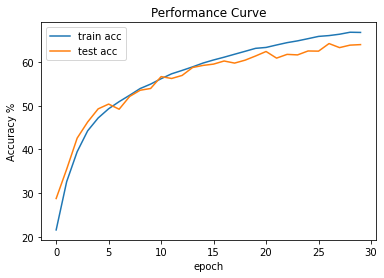

round: 2  total time used: 7.592666474978129
[1,  2000] loss:2.28651
[1,  4000] loss:2.11518
epoch: 1 train accuary: 0.21088  test accuary: 0.3202
[2,  2000] loss:1.85897
[2,  4000] loss:1.77912
epoch: 2 train accuary: 0.35098  test accuary: 0.3755
[3,  2000] loss:1.66655
[3,  4000] loss:1.60543
epoch: 3 train accuary: 0.40746  test accuary: 0.4293
[4,  2000] loss:1.53252
[4,  4000] loss:1.50652
epoch: 4 train accuary: 0.44992  test accuary: 0.4773
[5,  2000] loss:1.45956
[5,  4000] loss:1.42333
epoch: 5 train accuary: 0.48156  test accuary: 0.4969
[6,  2000] loss:1.39273
[6,  4000] loss:1.36614
epoch: 6 train accuary: 0.50492  test accuary: 0.5036
[7,  2000] loss:1.35222
[7,  4000] loss:1.31590
epoch: 7 train accuary: 0.52094  test accuary: 0.527
[8,  2000] loss:1.30824
[8,  4000] loss:1.29023
epoch: 8 train accuary: 0.53808  test accuary: 0.549
[9,  2000] loss:1.27057
[9,  4000] loss:1.25608
epoch: 9 train accuary: 0.54928  test accuary: 0.5393
[10,  2000] loss:1.24379
[10,  4000] lo

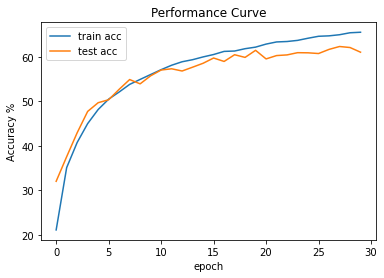

round: 3  total time used: 7.570565231641134
[1,  2000] loss:2.29132
[1,  4000] loss:2.14476
epoch: 1 train accuary: 0.1931  test accuary: 0.3034
[2,  2000] loss:1.89700
[2,  4000] loss:1.76052
epoch: 2 train accuary: 0.34264  test accuary: 0.3883
[3,  2000] loss:1.64784
[3,  4000] loss:1.60631
epoch: 3 train accuary: 0.40754  test accuary: 0.4379
[4,  2000] loss:1.54324
[4,  4000] loss:1.50794
epoch: 4 train accuary: 0.44386  test accuary: 0.4721
[5,  2000] loss:1.45256
[5,  4000] loss:1.44704
epoch: 5 train accuary: 0.47392  test accuary: 0.4739
[6,  2000] loss:1.40254
[6,  4000] loss:1.38186
epoch: 6 train accuary: 0.4953  test accuary: 0.5173
[7,  2000] loss:1.35122
[7,  4000] loss:1.34911
epoch: 7 train accuary: 0.51396  test accuary: 0.519
[8,  2000] loss:1.31113
[8,  4000] loss:1.31069
epoch: 8 train accuary: 0.53078  test accuary: 0.5338
[9,  2000] loss:1.27573
[9,  4000] loss:1.28236
epoch: 9 train accuary: 0.54394  test accuary: 0.5414
[10,  2000] loss:1.25481
[10,  4000] los

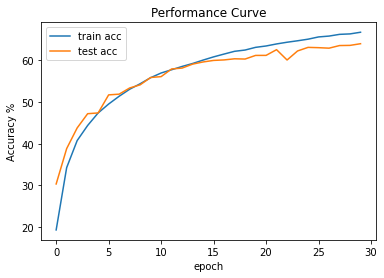

round: 4  total time used: 7.605739188194275
[1,  2000] loss:2.29973
[1,  4000] loss:2.28640
epoch: 1 train accuary: 0.15632  test accuary: 0.2185
[2,  2000] loss:2.01982
[2,  4000] loss:1.86756
epoch: 2 train accuary: 0.30546  test accuary: 0.3801
[3,  2000] loss:1.70103
[3,  4000] loss:1.63579
epoch: 3 train accuary: 0.39506  test accuary: 0.4218
[4,  2000] loss:1.57326
[4,  4000] loss:1.54104
epoch: 4 train accuary: 0.43592  test accuary: 0.4574
[5,  2000] loss:1.48894
[5,  4000] loss:1.48318
epoch: 5 train accuary: 0.46224  test accuary: 0.4839
[6,  2000] loss:1.43682
[6,  4000] loss:1.42628
epoch: 6 train accuary: 0.48638  test accuary: 0.5026
[7,  2000] loss:1.39497
[7,  4000] loss:1.37705
epoch: 7 train accuary: 0.50488  test accuary: 0.5111
[8,  2000] loss:1.33708
[8,  4000] loss:1.33786
epoch: 8 train accuary: 0.52262  test accuary: 0.5264
[9,  2000] loss:1.30755
[9,  4000] loss:1.29035
epoch: 9 train accuary: 0.53676  test accuary: 0.5478
[10,  2000] loss:1.26518
[10,  4000] 

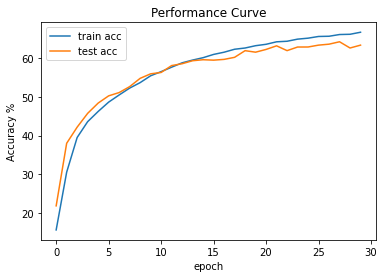

round: 5  total time used: 7.575841613610586
Best train accuracy among 5 runs: 66.84400000000001
Mean train accuracy among 5 runs: 66.34360000000001
Std train accuracy among 5 runs: 0.5311457803654286
Best test accuracy among 5 runs: 64.05
Mean test accuracy among 5 runs: 62.734
Std test accuracy among 5 runs: 1.3372299727421615


In [26]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_CIFAR_data(train_batch_size,test_batch_size)
channel=3
size=32
epoch=30
learning_rate=0.001
momentum=0.5
weight_decay=1e-2
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Files already downloaded and verified
Files already downloaded and verified
Data loaded
[1,  2000] loss:2.26492
[1,  4000] loss:1.84181
[1,  6000] loss:1.64013
epoch: 1 train accuary: 0.30266  test accuary: 0.4211
[2,  2000] loss:1.54082
[2,  4000] loss:1.47382
[2,  6000] loss:1.40713
epoch: 2 train accuary: 0.46444  test accuary: 0.4978
[3,  2000] loss:1.34747
[3,  4000] loss:1.31147
[3,  6000] loss:1.26818
epoch: 3 train accuary: 0.53028  test accuary: 0.5311
[4,  2000] loss:1.20928
[4,  4000] loss:1.20995
[4,  6000] loss:1.18966
epoch: 4 train accuary: 0.57234  test accuary: 0.5845
[5,  2000] loss:1.13531
[5,  4000] loss:1.12799
[5,  6000] loss:1.11805
epoch: 5 train accuary: 0.60084  test accuary: 0.5934
[6,  2000] loss:1.06763
[6,  4000] loss:1.07642
[6,  6000] loss:1.05872
epoch: 6 train accuary: 0.62484  test accuary: 0.5987
[7,  2000] loss:1.00988
[7,  4000] loss:1.01875
[7,  6000] loss:1.01345
epoch: 7 train accuary: 0.64398  test accuary: 0.6258
[8,  2000] loss:0.96727
[8,  4

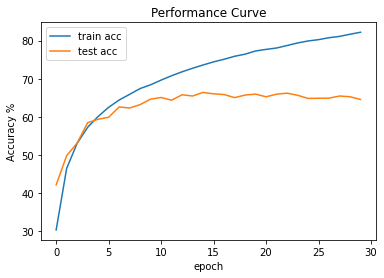

round: 1  total time used: 8.657920869191488
[1,  2000] loss:2.20370
[1,  4000] loss:1.90186
[1,  6000] loss:1.65290
epoch: 1 train accuary: 0.29036  test accuary: 0.4385
[2,  2000] loss:1.52845
[2,  4000] loss:1.44573
[2,  6000] loss:1.40532
epoch: 2 train accuary: 0.47272  test accuary: 0.5104
[3,  2000] loss:1.35326
[3,  4000] loss:1.30980
[3,  6000] loss:1.28963
epoch: 3 train accuary: 0.52898  test accuary: 0.5568
[4,  2000] loss:1.22956
[4,  4000] loss:1.21135
[4,  6000] loss:1.20714
epoch: 4 train accuary: 0.56794  test accuary: 0.5749
[5,  2000] loss:1.15633
[5,  4000] loss:1.13554
[5,  6000] loss:1.12876
epoch: 5 train accuary: 0.5989  test accuary: 0.5939
[6,  2000] loss:1.08168
[6,  4000] loss:1.08447
[6,  6000] loss:1.06437
epoch: 6 train accuary: 0.6207  test accuary: 0.6107
[7,  2000] loss:1.03737
[7,  4000] loss:1.01841
[7,  6000] loss:1.02071
epoch: 7 train accuary: 0.64088  test accuary: 0.6216
[8,  2000] loss:0.97567
[8,  4000] loss:0.98551
[8,  6000] loss:0.97632
epo

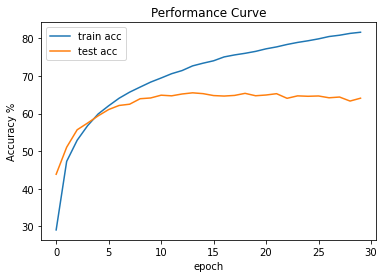

round: 2  total time used: 8.655217683315277
[1,  2000] loss:2.17726
[1,  4000] loss:1.78317
[1,  6000] loss:1.62624
epoch: 1 train accuary: 0.31622  test accuary: 0.4157
[2,  2000] loss:1.53521
[2,  4000] loss:1.47147
[2,  6000] loss:1.41215
epoch: 2 train accuary: 0.46756  test accuary: 0.4999
[3,  2000] loss:1.35114
[3,  4000] loss:1.32397
[3,  6000] loss:1.29320
epoch: 3 train accuary: 0.52758  test accuary: 0.5451
[4,  2000] loss:1.23870
[4,  4000] loss:1.21294
[4,  6000] loss:1.20179
epoch: 4 train accuary: 0.56708  test accuary: 0.5744
[5,  2000] loss:1.14857
[5,  4000] loss:1.14118
[5,  6000] loss:1.13249
epoch: 5 train accuary: 0.598  test accuary: 0.5805
[6,  2000] loss:1.08802
[6,  4000] loss:1.08010
[6,  6000] loss:1.07646
epoch: 6 train accuary: 0.61892  test accuary: 0.6015
[7,  2000] loss:1.03102
[7,  4000] loss:1.01651
[7,  6000] loss:1.04422
epoch: 7 train accuary: 0.64  test accuary: 0.5997
[8,  2000] loss:0.97451
[8,  4000] loss:0.99535
[8,  6000] loss:0.99398
epoch:

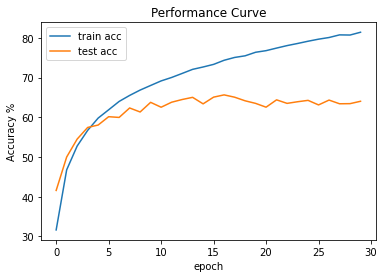

round: 3  total time used: 8.644250071048736
[1,  2000] loss:2.27336
[1,  4000] loss:1.86654
[1,  6000] loss:1.66815
epoch: 1 train accuary: 0.2842  test accuary: 0.4208
[2,  2000] loss:1.54761
[2,  4000] loss:1.48751
[2,  6000] loss:1.44432
epoch: 2 train accuary: 0.45356  test accuary: 0.4868
[3,  2000] loss:1.35840
[3,  4000] loss:1.35325
[3,  6000] loss:1.29547
epoch: 3 train accuary: 0.52004  test accuary: 0.5369
[4,  2000] loss:1.24634
[4,  4000] loss:1.22677
[4,  6000] loss:1.20404
epoch: 4 train accuary: 0.56086  test accuary: 0.5579
[5,  2000] loss:1.16483
[5,  4000] loss:1.15149
[5,  6000] loss:1.13344
epoch: 5 train accuary: 0.58778  test accuary: 0.5876
[6,  2000] loss:1.07915
[6,  4000] loss:1.09027
[6,  6000] loss:1.08573
epoch: 6 train accuary: 0.61564  test accuary: 0.6091
[7,  2000] loss:1.02784
[7,  4000] loss:1.03268
[7,  6000] loss:1.02176
epoch: 7 train accuary: 0.63636  test accuary: 0.6249
[8,  2000] loss:0.96788
[8,  4000] loss:0.98872
[8,  6000] loss:0.99576
ep

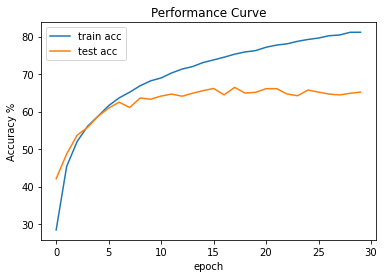

round: 4  total time used: 8.64816610813141
[1,  2000] loss:2.17914
[1,  4000] loss:1.88162
[1,  6000] loss:1.70744
epoch: 1 train accuary: 0.29742  test accuary: 0.421
[2,  2000] loss:1.57535
[2,  4000] loss:1.48843
[2,  6000] loss:1.42521
epoch: 2 train accuary: 0.4609  test accuary: 0.4818
[3,  2000] loss:1.35201
[3,  4000] loss:1.33781
[3,  6000] loss:1.28529
epoch: 3 train accuary: 0.52662  test accuary: 0.5345
[4,  2000] loss:1.23235
[4,  4000] loss:1.19874
[4,  6000] loss:1.19915
epoch: 4 train accuary: 0.56944  test accuary: 0.563
[5,  2000] loss:1.14351
[5,  4000] loss:1.12712
[5,  6000] loss:1.12052
epoch: 5 train accuary: 0.60088  test accuary: 0.5913
[6,  2000] loss:1.07077
[6,  4000] loss:1.05472
[6,  6000] loss:1.07460
epoch: 6 train accuary: 0.62438  test accuary: 0.6095
[7,  2000] loss:1.01814
[7,  4000] loss:1.03127
[7,  6000] loss:1.00296
epoch: 7 train accuary: 0.6429  test accuary: 0.6244
[8,  2000] loss:0.95063
[8,  4000] loss:0.98681
[8,  6000] loss:0.97295
epoch:

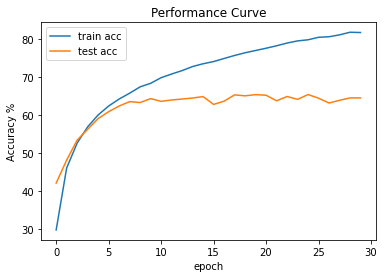

round: 5  total time used: 8.646471107006073
Best train accuracy among 5 runs: 82.208
Mean train accuracy among 5 runs: 81.6528
Std train accuracy among 5 runs: 0.36018795093672773
Best test accuracy among 5 runs: 65.18
Mean test accuracy among 5 runs: 64.486
Std test accuracy among 5 runs: 0.41209707594206796


In [27]:
train_batch_size=8
test_batch_size=1000
trainloader,testloader=load_CIFAR_data(train_batch_size,test_batch_size)
channel=3
size=32
epoch=30
learning_rate=0.0005
momentum=0.9
weight_decay=1e-3
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)


Files already downloaded and verified
Files already downloaded and verified
Data loaded
[1,  2000] loss:2.25320
[1,  4000] loss:1.91763
epoch: 1 train accuary: 0.25162  test accuary: 0.3943
[2,  2000] loss:1.63148
[2,  4000] loss:1.57046
epoch: 2 train accuary: 0.41864  test accuary: 0.4319
[3,  2000] loss:1.47489
[3,  4000] loss:1.43729
epoch: 3 train accuary: 0.47682  test accuary: 0.5068
[4,  2000] loss:1.38423
[4,  4000] loss:1.33968
epoch: 4 train accuary: 0.51432  test accuary: 0.5415
[5,  2000] loss:1.29864
[5,  4000] loss:1.28188
epoch: 5 train accuary: 0.54082  test accuary: 0.5486
[6,  2000] loss:1.23995
[6,  4000] loss:1.23120
epoch: 6 train accuary: 0.56148  test accuary: 0.5601
[7,  2000] loss:1.19144
[7,  4000] loss:1.20534
epoch: 7 train accuary: 0.5773  test accuary: 0.5749
[8,  2000] loss:1.16246
[8,  4000] loss:1.16782
epoch: 8 train accuary: 0.58754  test accuary: 0.564
[9,  2000] loss:1.13977
[9,  4000] loss:1.13660
epoch: 9 train accuary: 0.59816  test accuary: 0.5

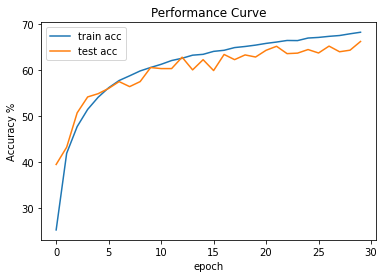

round: 1  total time used: 7.59773051738739
[1,  2000] loss:2.20444
[1,  4000] loss:1.81479
epoch: 1 train accuary: 0.28002  test accuary: 0.4002
[2,  2000] loss:1.58242
[2,  4000] loss:1.53597
epoch: 2 train accuary: 0.43318  test accuary: 0.4676
[3,  2000] loss:1.45031
[3,  4000] loss:1.43177
epoch: 3 train accuary: 0.4792  test accuary: 0.4968
[4,  2000] loss:1.38108
[4,  4000] loss:1.36933
epoch: 4 train accuary: 0.50516  test accuary: 0.5237
[5,  2000] loss:1.30660
[5,  4000] loss:1.31553
epoch: 5 train accuary: 0.53092  test accuary: 0.5233
[6,  2000] loss:1.27334
[6,  4000] loss:1.26267
epoch: 6 train accuary: 0.55064  test accuary: 0.5646
[7,  2000] loss:1.22188
[7,  4000] loss:1.21283
epoch: 7 train accuary: 0.57168  test accuary: 0.5665
[8,  2000] loss:1.19844
[8,  4000] loss:1.17325
epoch: 8 train accuary: 0.58088  test accuary: 0.5855
[9,  2000] loss:1.14761
[9,  4000] loss:1.15096
epoch: 9 train accuary: 0.59254  test accuary: 0.5738
[10,  2000] loss:1.11812
[10,  4000] lo

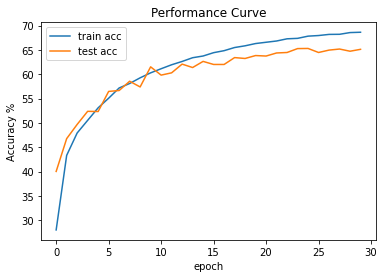

round: 2  total time used: 7.557502909501394
[1,  2000] loss:2.19123
[1,  4000] loss:1.85834
epoch: 1 train accuary: 0.27328  test accuary: 0.3899
[2,  2000] loss:1.63133
[2,  4000] loss:1.54576
epoch: 2 train accuary: 0.42482  test accuary: 0.4647
[3,  2000] loss:1.47472
[3,  4000] loss:1.43319
epoch: 3 train accuary: 0.47466  test accuary: 0.5079
[4,  2000] loss:1.37283
[4,  4000] loss:1.35428
epoch: 4 train accuary: 0.50672  test accuary: 0.5258
[5,  2000] loss:1.30312
[5,  4000] loss:1.29255
epoch: 5 train accuary: 0.5349  test accuary: 0.5316
[6,  2000] loss:1.24087
[6,  4000] loss:1.25493
epoch: 6 train accuary: 0.55502  test accuary: 0.561
[7,  2000] loss:1.20875
[7,  4000] loss:1.21135
epoch: 7 train accuary: 0.57136  test accuary: 0.5704
[8,  2000] loss:1.17187
[8,  4000] loss:1.18032
epoch: 8 train accuary: 0.5824  test accuary: 0.5726
[9,  2000] loss:1.14522
[9,  4000] loss:1.15194
epoch: 9 train accuary: 0.59036  test accuary: 0.5778
[10,  2000] loss:1.12122
[10,  4000] los

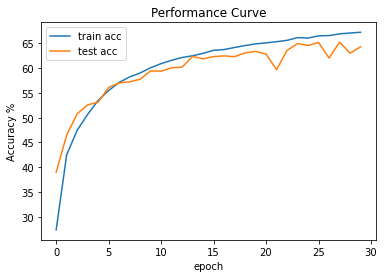

round: 3  total time used: 7.578514345486959
[1,  2000] loss:2.20067
[1,  4000] loss:1.85374
epoch: 1 train accuary: 0.28438  test accuary: 0.3896
[2,  2000] loss:1.60920
[2,  4000] loss:1.54318
epoch: 2 train accuary: 0.42826  test accuary: 0.462
[3,  2000] loss:1.47693
[3,  4000] loss:1.42527
epoch: 3 train accuary: 0.47722  test accuary: 0.5119
[4,  2000] loss:1.35634
[4,  4000] loss:1.32301
epoch: 4 train accuary: 0.52192  test accuary: 0.5076
[5,  2000] loss:1.26681
[5,  4000] loss:1.24816
epoch: 5 train accuary: 0.55012  test accuary: 0.5595
[6,  2000] loss:1.21238
[6,  4000] loss:1.19968
epoch: 6 train accuary: 0.57308  test accuary: 0.5775
[7,  2000] loss:1.15793
[7,  4000] loss:1.15225
epoch: 7 train accuary: 0.5923  test accuary: 0.5897
[8,  2000] loss:1.13060
[8,  4000] loss:1.11867
epoch: 8 train accuary: 0.60314  test accuary: 0.5877
[9,  2000] loss:1.09407
[9,  4000] loss:1.09360
epoch: 9 train accuary: 0.61638  test accuary: 0.6087
[10,  2000] loss:1.08166
[10,  4000] lo

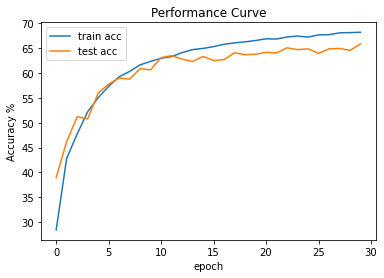

round: 4  total time used: 7.750844132900238
[1,  2000] loss:2.24699
[1,  4000] loss:1.88897
epoch: 1 train accuary: 0.25646  test accuary: 0.3833
[2,  2000] loss:1.63057
[2,  4000] loss:1.54972
epoch: 2 train accuary: 0.4185  test accuary: 0.4396
[3,  2000] loss:1.45375
[3,  4000] loss:1.40469
epoch: 3 train accuary: 0.48394  test accuary: 0.4908
[4,  2000] loss:1.35335
[4,  4000] loss:1.32250
epoch: 4 train accuary: 0.51674  test accuary: 0.5225
[5,  2000] loss:1.27352
[5,  4000] loss:1.27361
epoch: 5 train accuary: 0.54414  test accuary: 0.5611
[6,  2000] loss:1.23350
[6,  4000] loss:1.22316
epoch: 6 train accuary: 0.56216  test accuary: 0.5679
[7,  2000] loss:1.19480
[7,  4000] loss:1.20389
epoch: 7 train accuary: 0.57594  test accuary: 0.572
[8,  2000] loss:1.16158
[8,  4000] loss:1.17342
epoch: 8 train accuary: 0.58658  test accuary: 0.5708
[9,  2000] loss:1.15062
[9,  4000] loss:1.14388
epoch: 9 train accuary: 0.59722  test accuary: 0.5924
[10,  2000] loss:1.11367
[10,  4000] lo

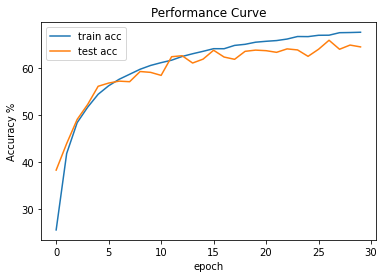

round: 5  total time used: 7.758293124039968
Best train accuracy among 5 runs: 68.62
Mean train accuracy among 5 runs: 67.9804
Std train accuracy among 5 runs: 0.48837592078234376
Best test accuracy among 5 runs: 66.24
Mean test accuracy among 5 runs: 65.198
Std test accuracy among 5 runs: 0.7505571264067772


In [31]:
train_batch_size=10
test_batch_size=1000
trainloader,testloader=load_CIFAR_data(train_batch_size,test_batch_size)
channel=3
size=32
epoch=30
learning_rate=0.0005
momentum=0.9
weight_decay=1e-2
meanTrainResults(0,device,train_batch_size,test_batch_size,trainloader,testloader,channel,size,epoch,learning_rate,momentum,weight_decay)
